# Problem Set 5: Trees, Forests, and Networks


## Part 1: Exploring The Titanic

Your mission for this problem set is to use your knowledge of supervised machine learning to try to predict which passengers aboard the Titanic were most likely to survive. The prompts for this part of the problem set are deliberately vague - the goal is to leave it up to you how to structure (most of) your analysis. We **highly recommend** you closely go over the entire problem set once before starting; this is important, so that you understand the sequence of steps and not perform redundant work.

To get started, read about the prediction problem on [Kaggle](https://www.kaggle.com/c/titanic). Then, download the data [here](https://www.kaggle.com/c/titanic/data) - you'll need the `train.csv` data. Treat this as your entire dataset, and further build train and test splits from this dataset whenever required. 

### 1.1 Exploratory data analysis

Create 2-3 figures and tables that help give you a feel for the data. Make sure to at least check the data type of each variable, to understand which variables have missing observations, and to understand the distribution of each variable (and determine whether the variables should be standardized or not). Are any of the potential predictor variables (i.e., anything execpt for survival) collinear or highly correlated? Remember that this is the EDA phase, and we want to save pre-processing steps like imputations, transformations etc. and feature engineering for later.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score

In [260]:
# loading data
df = pd.read_csv ('train.csv')
# inspecting columns
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [261]:
# inspecting dataset
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [262]:
# checking null values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [263]:
# inspecting data types
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

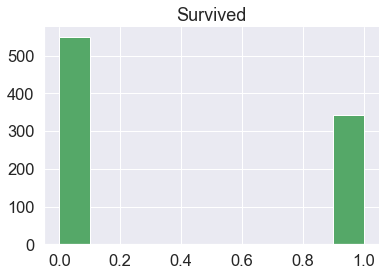

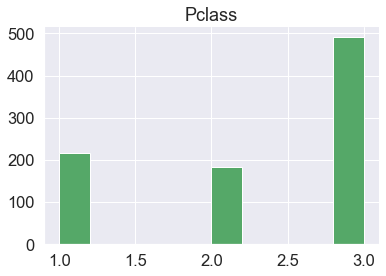

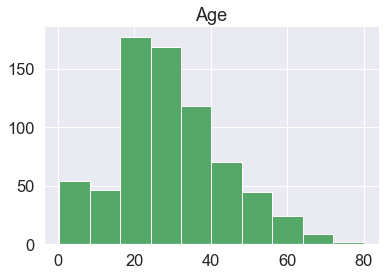

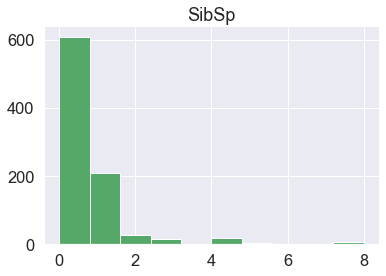

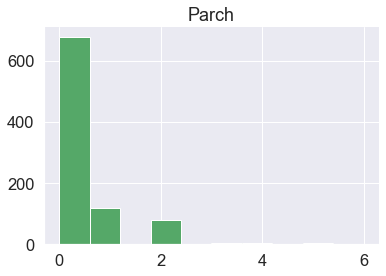

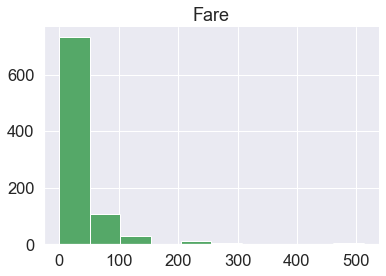

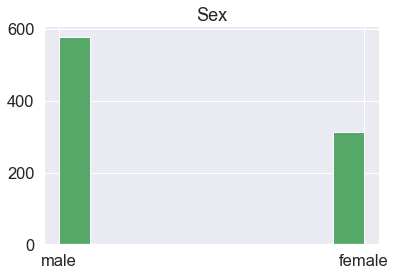

In [264]:
#inspecting distributions of variables
col = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex']

for i in col:
    plt.hist(df[i], facecolor='g', edgecolor='white')
    plt.title(i)
   

    #polishing
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    plt.gca().yaxis.grid(True) # Add horizontal grid lines
    plt.show()

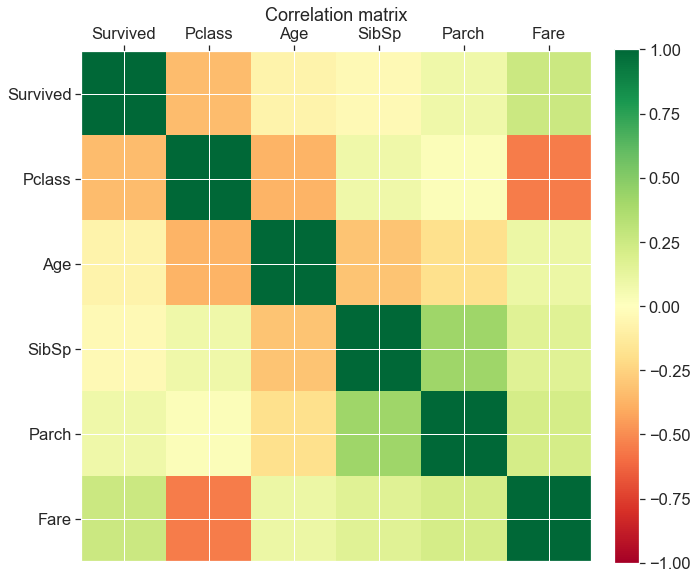

In [265]:
#inspecting correlation matrix
df2 = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]

fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(111)

mat = axes.matshow(df2.corr(method='pearson'), vmin=-1, vmax=1, cmap=plt.cm.RdYlGn)

fig.colorbar(mat,fraction=0.046, pad=0.04)
axes.set_title('Correlation matrix')
axes.set_xticks(range(len(df2.columns)))
axes.set_xticklabels(df2.columns)
axes.set_yticks(range(len(df2.columns)))
axes.set_yticklabels(df2.columns)
axes.xaxis.set_ticks_position('top')
axes.yaxis.set_ticks_position('left')

plt.show()

It appears that Fare is the most highly correlated with Survived and Pclass is strongly negatively correlated. There are many null values.

### 1.2 Correlates of survival

Use whatever methods you can think of to try and figure out what factors seem to determine whether or not a person would survive the sinking of the Titanic. You can start with simple correlations, but will likely also want to use multiple regression and/or other methods in your toolkit. What do you conclude?

In [266]:
#correlation
df.corr(method='pearson')

PassengerId  Survived    Pclass       Age     SibSp     Parch  \
PassengerId     1.000000 -0.005007 -0.035144  0.036847 -0.057527 -0.001652   
Survived       -0.005007  1.000000 -0.338481 -0.077221 -0.035322  0.081629   
Pclass         -0.035144 -0.338481  1.000000 -0.369226  0.083081  0.018443   
Age             0.036847 -0.077221 -0.369226  1.000000 -0.308247 -0.189119   
SibSp          -0.057527 -0.035322  0.083081 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.081629  0.018443 -0.189119  0.414838  1.000000   
Fare            0.012658  0.257307 -0.549500  0.096067  0.159651  0.216225   

                 Fare  
PassengerId  0.012658  
Survived     0.257307  
Pclass      -0.549500  
Age          0.096067  
SibSp        0.159651  
Parch        0.216225  
Fare         1.000000

In [267]:
from sklearn.linear_model import LogisticRegression

In [268]:
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [269]:
# since we are regressing on a binary variable, we will use logisitc regression and standardize our variables
X1 = standardize(np.array(df[['Fare']]))
y1 = np.array(df['Survived'])
model1 = LogisticRegression(solver='liblinear', random_state=0)
model1.fit(X1, y1)
print("Coef_: ",model1.coef_)
print("Intercept_: ",model1.intercept_)


X2 = standardize(np.array(df[['Pclass']]))
model2 = LogisticRegression(solver='liblinear', random_state=0)
model2.fit(X2, y1)
print("Coef_: ",model2.coef_)
print("Intercept_: ",model2.intercept_)

Coef_:  [[0.7460968]]
Intercept_:  [-0.45033943]
Coef_:  [[-0.70634223]]
Intercept_:  [-0.51265842]


I chose to use logisitc regression, as we are predicting a binary variable. Our first regression tells us that increasing the Fare by 1 unit multiplies the odds of surviving by e^.746.  Our second regression tells us that increasing Class by 1 unit multiplies the odds of surviving by e^-.706.

### 1.3 Preprocessing steps
Take whatever pre-processing steps you believe are necessary for each variable in the dataset (for example, these might include normalization, standardization, log transforms, dummy-encoding, or dropping a variable altogether). For now, you can ignore null values in the dataset --- we'll come back to those later. Create a table describing the preprocessing step for each variable. Make sure the variables are alphabetized and your table is well-organized.

In [270]:
#Refactor Sex into a binary variable where male=1 female=0
sex_dict = {"female":0 ,"male":1} 
df['Sex'] = df['Sex'].replace(sex_dict)
df['Sex'] = pd.to_numeric(df['Sex'])
#One-hot encoding for port of embark
df.loc[df['Embarked'] == 'S', 'Embarked_S'] = 1 
df.loc[df['Embarked'] != 'S', 'Embarked_S'] = 0 
df.loc[df['Embarked'] == 'C', 'Embarked_C'] = 1 
df.loc[df['Embarked'] != 'C', 'Embarked_C'] = 0
df.loc[df['Embarked'] == 'Q', 'Embarked_Q'] = 1 
df.loc[df['Embarked'] != 'Q', 'Embarked_Q'] = 0

df_ = df.drop(['Embarked','Sex','PassengerId','Name','Ticket','Cabin'], axis=1)
df_ = df_.dropna()

## Part 2: Decision Trees
### 2.1 Decision Tree
Using the basic [Decision Tree Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)  in sklearn, fit a model to predict titanic survival, using 10-fold cross-validation. For this and the following problems, you should set aside some (20%) of your training data as held-out test data, prior to cross-validation. 

Begin by using the default hyperparameters, and report the average training and cross-validated accuracy across the 10 folds.  Then, fit a single decision tree model on all of the training data (i.e., no cross-validation in this particular step), and report the performance of this fitted model on the held-out test data -- how does it compare to the cross-validated accuracy? Finally, show a diagram of this tree (at least the first three levels of splits), and provide a couple sentences interpreting the tree diagram.

NOTE - You may drop columns with null values for now; we'll come back to those columns later in the problem set.

In [271]:
print(df_.columns)

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_S',
       'Embarked_C', 'Embarked_Q'],
      dtype='object')


In [272]:
from sklearn.model_selection import train_test_split
from sklearn import tree

# splitting data into train/test sets
training_data, testing_data = train_test_split(df_, test_size=0.2, random_state=0)
X_train = training_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_S',
       'Embarked_C', 'Embarked_Q']]
Y_train = training_data['Survived']
X_test = testing_data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_S',
       'Embarked_C', 'Embarked_Q']]
Y_test = testing_data['Survived']


In [273]:
from sklearn.model_selection import KFold

#default model cross-val
kf = KFold(n_splits=10, random_state=0, shuffle=True)
clf = sklearn.tree.DecisionTreeClassifier(random_state=0)

train_scores = []
test_scores = []

for train_index, test_index in kf.split(X_train):
    x_train , x_test = np.array(X_train)[train_index],np.array(X_train)[test_index]
    y_train , y_test = np.array(Y_train)[train_index] , np.array(Y_train)[test_index]
    model = clf.fit(x_train,y_train)
    yhat_train = model.predict(x_train)
    yhat_test = model.predict(x_test)
    
    
    train_scores.append(accuracy_score(y_train, yhat_train))
    test_scores.append(accuracy_score(y_test, yhat_test))
    
print(np.mean(train_scores))
print(np.mean(test_scores))

0.9803460228608702
0.6410768300060496


0.978984238178634
0.6363636363636364


[Text(0.5, 0.9, 'Pclass <= 2.5\ngini = 0.478\nsamples = 571\nvalue = [345, 226]\nclass = s'),
 Text(0.21153846153846154, 0.7, 'Fare <= 13.646\ngini = 0.493\nsamples = 280\nvalue = [124, 156]\nclass = u'),
 Text(0.07692307692307693, 0.5, 'Embarked_S <= 0.5\ngini = 0.404\nsamples = 64\nvalue = [46, 18]\nclass = s'),
 Text(0.038461538461538464, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = u'),
 Text(0.11538461538461539, 0.3, 'Age <= 26.5\ngini = 0.383\nsamples = 62\nvalue = [46, 16]\nclass = s'),
 Text(0.07692307692307693, 0.1, '\n  (...)  \n'),
 Text(0.15384615384615385, 0.1, '\n  (...)  \n'),
 Text(0.34615384615384615, 0.5, 'Age <= 53.5\ngini = 0.461\nsamples = 216\nvalue = [78, 138]\nclass = u'),
 Text(0.2692307692307692, 0.3, 'Parch <= 0.5\ngini = 0.428\nsamples = 187\nvalue = [58, 129]\nclass = u'),
 Text(0.23076923076923078, 0.1, '\n  (...)  \n'),
 Text(0.3076923076923077, 0.1, '\n  (...)  \n'),
 Text(0.4230769230769231, 0.3, 'Fare <= 77.623\ngini = 0.428\nsamples = 29\nva

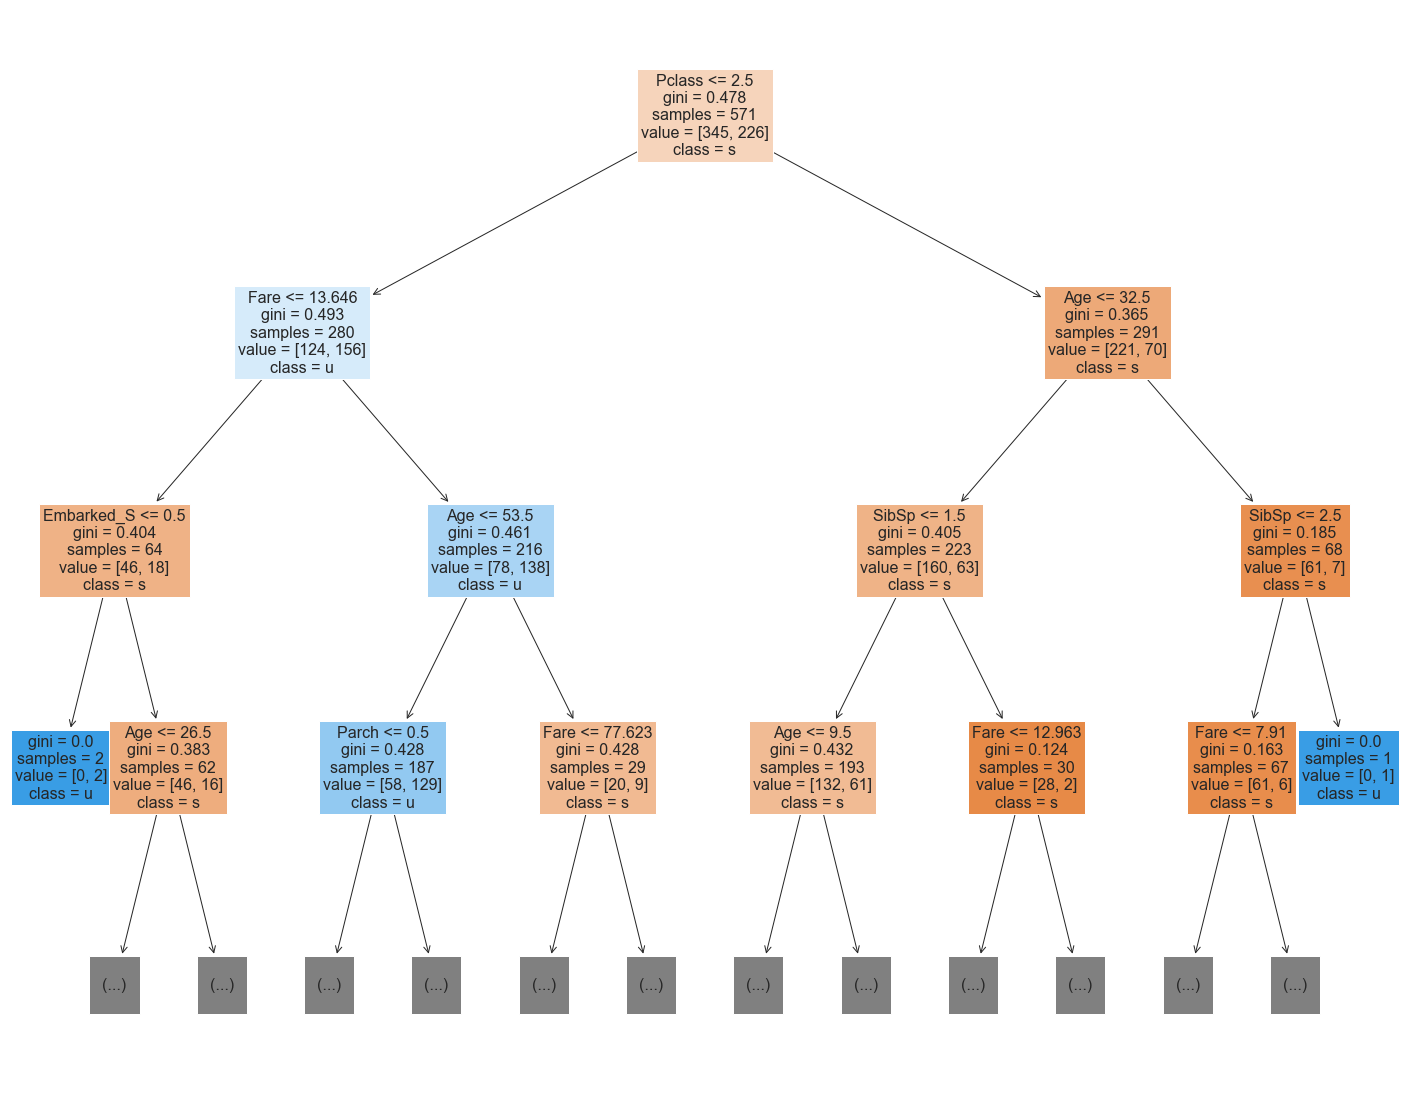

In [274]:
# fitting a single decision tree model on all of the training data
model2 = clf.fit(X_train,Y_train)
pred_train = model2.predict(X_train)
pred_test = model2.predict(X_test)
# report the performance of this fitted model on the held-out test data 
score_train = accuracy_score(Y_train,pred_train)
score_test = accuracy_score(Y_test, pred_test)
print(score_train)
print(score_test)

# plotting
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model2, 
                   feature_names = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_S',
       'Embarked_C', 'Embarked_Q'],  
                   class_names= 'survived',
                   max_depth = 3, 
                   filled=True,
                   fontsize=16)

Average Training Accuracy: 0.9803460228608702
Average Test Acccuracy (cross-validated accuracy): 0.6410768300060496
Fitted Tree Test Accuracy: 0.6363636363636364

We can see that the fitted tree run on all the data performs slighly worse than the cross validated test accuracy.

Based on our tree diagram, we can see that this model first splits our data by class, which was the most negatively correlated value we found above. For the group where class is <= 2.5, our data is then split by Fare, the next highest correlation. For our data where class is greater than 2.5, our data is split by age, then by the amount of siblings/spouses.

### 2.2 Hyperparameter: Maximum Depth

Use all of the data (minus the held-out data) to re-fit a single decision tree with `max_depth = 4` (i.e., no cross-validation). Show the tree diagram and also plot the feature importance. What do you observe? How does the performance of this tree compare to the tree from 2.1?

[Text(0.5, 0.9, 'Pclass <= 2.5\ngini = 0.478\nsamples = 571\nvalue = [345, 226]\nclass = s'),
 Text(0.21153846153846154, 0.7, 'Fare <= 13.646\ngini = 0.493\nsamples = 280\nvalue = [124, 156]\nclass = u'),
 Text(0.07692307692307693, 0.5, 'Embarked_S <= 0.5\ngini = 0.404\nsamples = 64\nvalue = [46, 18]\nclass = s'),
 Text(0.038461538461538464, 0.3, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = u'),
 Text(0.11538461538461539, 0.3, 'Age <= 26.5\ngini = 0.383\nsamples = 62\nvalue = [46, 16]\nclass = s'),
 Text(0.07692307692307693, 0.1, 'gini = 0.198\nsamples = 18\nvalue = [16, 2]\nclass = s'),
 Text(0.15384615384615385, 0.1, 'gini = 0.434\nsamples = 44\nvalue = [30, 14]\nclass = s'),
 Text(0.34615384615384615, 0.5, 'Age <= 53.5\ngini = 0.461\nsamples = 216\nvalue = [78, 138]\nclass = u'),
 Text(0.2692307692307692, 0.3, 'Parch <= 0.5\ngini = 0.428\nsamples = 187\nvalue = [58, 129]\nclass = u'),
 Text(0.23076923076923078, 0.1, 'gini = 0.479\nsamples = 116\nvalue = [46, 70]\nclass = u'),
 

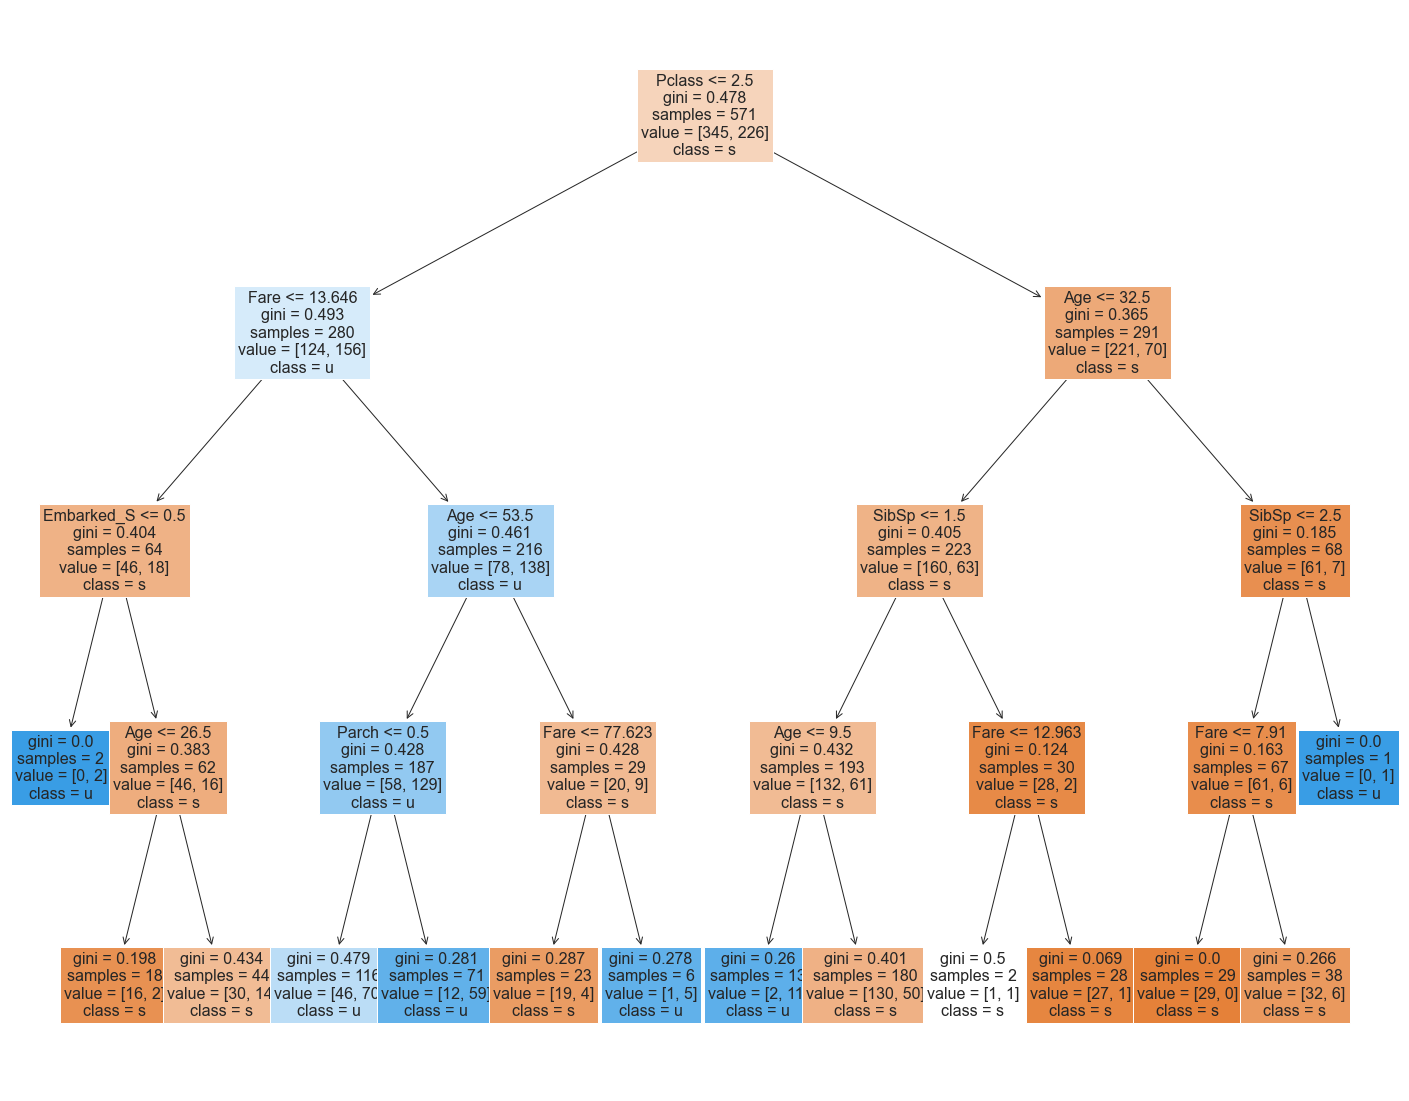

In [275]:
# refit a single decision tree with max_depth = 4 with all data (minus held-out data)
clf2 = sklearn.tree.DecisionTreeClassifier(random_state=0, max_depth=4)

model3 = clf2.fit(X_train,Y_train)
pred2 = model3.predict(X_train)

# tree diagram
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model3, 
                   feature_names = X_train.columns,  
                   class_names= 'survived',
                   max_depth = 4, 
                   filled=True,
                   fontsize=16)

We can see that in this tree, our features are split in the same pattern as the previous tree, in line with our correlation analysis.

In [116]:
# feature importance
importances = model3.feature_importances_
importances = pd.DataFrame([X_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=False)[:10]

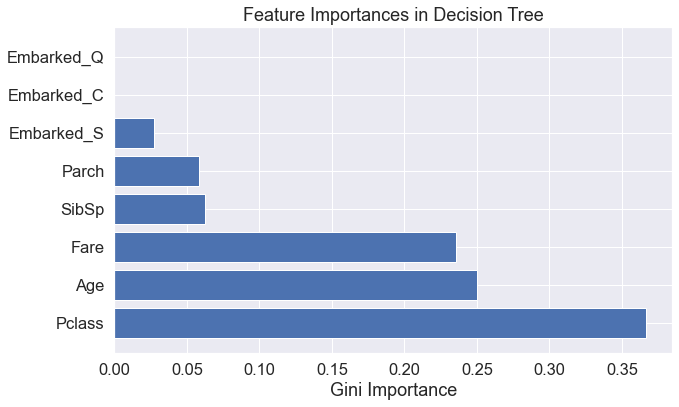

In [117]:
# Bar chart
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
ax.set_xlabel('Gini Importance')
ax.set_title('Feature Importances in Decision Tree')
plt.show()

It appears that the most important feature for our tree is Pclass, followed by Age, and then Fare. 

### 2.3  Tuning Hyperparameters
The built-in algorithm you are using has several parameters which you can tune. Using cross-validation, show how the choice of these parameters affects performance.

First, show how `max_depth` affects train and cross-validated accuracy. On a single axis, plot train and cross-validated accuracy as a function of `max_depth`. Use a red line to show cross-validated accuracy and a blue line to show train accuracy. Do not use your held-out test data yet.

Second, show how cross-validated accuracy relates to both `max_depth` and `min_samples_leaf`. Specifically, create a 3-D plot where the x-axis is `max_depth`, the y-axis is `min_samples_leaf`, and the z-axis shows cross-validated accuracy. What combination of `max_depth` and `min-samples_leaf` achieves the highest accuracy? How sensitive are the results to these two parameters?

Finally, select the the best hyperparameters that you got through cross-validation, and fit a single decision tree on all of the training data using those hyperparameters. Display this tree and report the accuracy of this tree on the held-out data.

In [281]:
# tuning max depth with cross-val
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8, 10, 12, 14]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, Y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.003489      0.001566         0.001542        0.000591   
1       0.002125      0.000089         0.001145        0.000128   
2       0.001693      0.000078         0.000858        0.000032   
3       0.001830      0.000023         0.000928        0.000037   
4       0.001860      0.000034         0.000899        0.000032   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               2   {'max_depth': 2}           0.623037           0.678947   
1               4   {'max_depth': 4}           0.680628           0.678947   
2               6   {'max_depth': 6}           0.670157           0.705263   
3               8   {'max_depth': 8}           0.691099           0.689474   
4              10  {'max_depth': 10}           0.706806           0.715789   

   split2_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.663158         0.655047        0.023535                7   
1           0.752632         0.704069        0.034346                2   
2           0.715789         0.697070        0.019509                3   
3           0.705263         0.695279        0.007091                4   
4           0.700000         0.707532        0.006466                1   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.702632            0.687664            0.729659   
1            0.752632            0.766404            0.769029   
2            0.823684            0.824147            0.800525   
3            0.876316            0.868766            0.839895   
4            0.913158            0.905512            0.884514   

   mean_train_score  std_train_score  
0          0.706651         0.017378  
1          0.762688         0.007191  
2          0.816119         0.011028  
3          0.861659         0.015695  
4          0.901061         0.012110

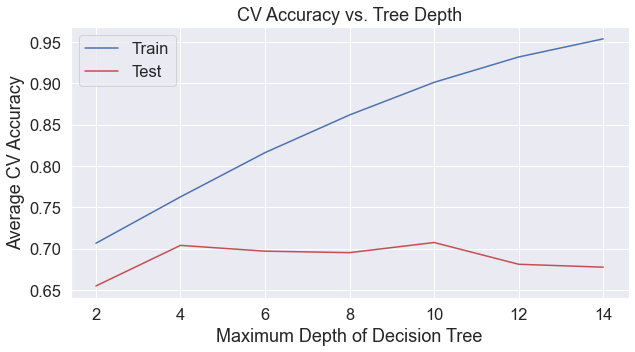

In [282]:
# Plot CV accuracy as a function of maximum depth
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(cv_results['param_max_depth'], cv_results['mean_train_score'], label='Train',color='b')
ax.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], label='Test',color='r')
ax.set_xlabel('Maximum Depth of Decision Tree')
ax.set_ylabel('Average CV Accuracy')
ax.set_title('CV Accuracy vs. Tree Depth')
ax.legend(loc='best')
plt.show()

Second, show how cross-validated accuracy relates to both `max_depth` and `min_samples_leaf`. Specifically, create a 3-D plot where the x-axis is `max_depth`, the y-axis is `min_samples_leaf`, and the z-axis shows cross-validated accuracy. What combination of `max_depth` and `min-samples_leaf` achieves the highest accuracy? How sensitive are the results to these two parameters?

Finally, select the the best hyperparameters that you got through cross-validation, and fit a single decision tree on all of the training data using those hyperparameters. Display this tree and report the accuracy of this tree on the held-out data.

In [283]:
# tuning max depth and min samples leaf with cross-val
cv = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8, 10, 12, 14], 'min_samples_leaf':[1,2,3,4,5]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, Y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002659      0.001312         0.001320        0.000519   
1       0.001382      0.000160         0.000780        0.000097   
2       0.001142      0.000018         0.000670        0.000038   
3       0.001123      0.000004         0.000648        0.000009   
4       0.001120      0.000007         0.000648        0.000006   

  param_max_depth param_min_samples_leaf  \
0               2                      1   
1               2                      2   
2               2                      3   
3               2                      4   
4               2                      5   

                                    params  split0_test_score  \
0  {'max_depth': 2, 'min_samples_leaf': 1}           0.568966   
1  {'max_depth': 2, 'min_samples_leaf': 2}           0.568966   
2  {'max_depth': 2, 'min_samples_leaf': 3}           0.568966   
3  {'max_depth': 2, 'min_samples_leaf': 4}           0.568966   
4  {'max_depth': 2, 'min_samples_leaf': 5}           0.568966   

   split1_test_score  split2_test_score  ...  split2_train_score  \
0           0.684211           0.736842  ...            0.677043   
1           0.684211           0.736842  ...            0.677043   
2           0.684211           0.736842  ...            0.677043   
3           0.684211           0.736842  ...            0.677043   
4           0.684211           0.736842  ...            0.677043   

   split3_train_score  split4_train_score  split5_train_score  \
0            0.725681            0.708171            0.690661   
1            0.725681            0.708171            0.690661   
2            0.725681            0.708171            0.690661   
3            0.725681            0.708171            0.690661   
4            0.725681            0.708171            0.690661   

   split6_train_score  split7_train_score  split8_train_score  \
0            0.710117            0.682879            0.717899   
1            0.710117            0.682879            0.717899   
2            0.710117            0.682879            0.717899   
3            0.710117            0.682879            0.717899   
4            0.710117            0.682879            0.717899   

   split9_train_score  mean_train_score  std_train_score  
0            0.731518          0.705199         0.018836  
1            0.729572          0.705005         0.018571  
2            0.729572          0.705005         0.018571  
3            0.729572          0.705005         0.018571  
4            0.729572          0.705005         0.018571  

[5 rows x 32 columns]

In [284]:
print(cv_model.best_params_)


{'max_depth': 8, 'min_samples_leaf': 1}


In [285]:
print(cv_results[(cv_results.param_min_samples_leaf == 1) & (cv_results.param_max_depth == 8)][['mean_test_score']])


    mean_test_score
15         0.700484


In [291]:
print('Min accuracy: ' + str(min(cv_results['mean_test_score'])))
print('Max accuracy: ' + str(max(cv_results['mean_test_score'])))

Min accuracy: 0.6428614640048397
Max accuracy: 0.7004839685420448


The best parameters we found through cross validation for this model are max_depth: 8 and min_samples_leaf: 1. 
Looking at the range of accuracies, we can see that our range is large enough to determine that our accuracy is sensitive to our parameters.

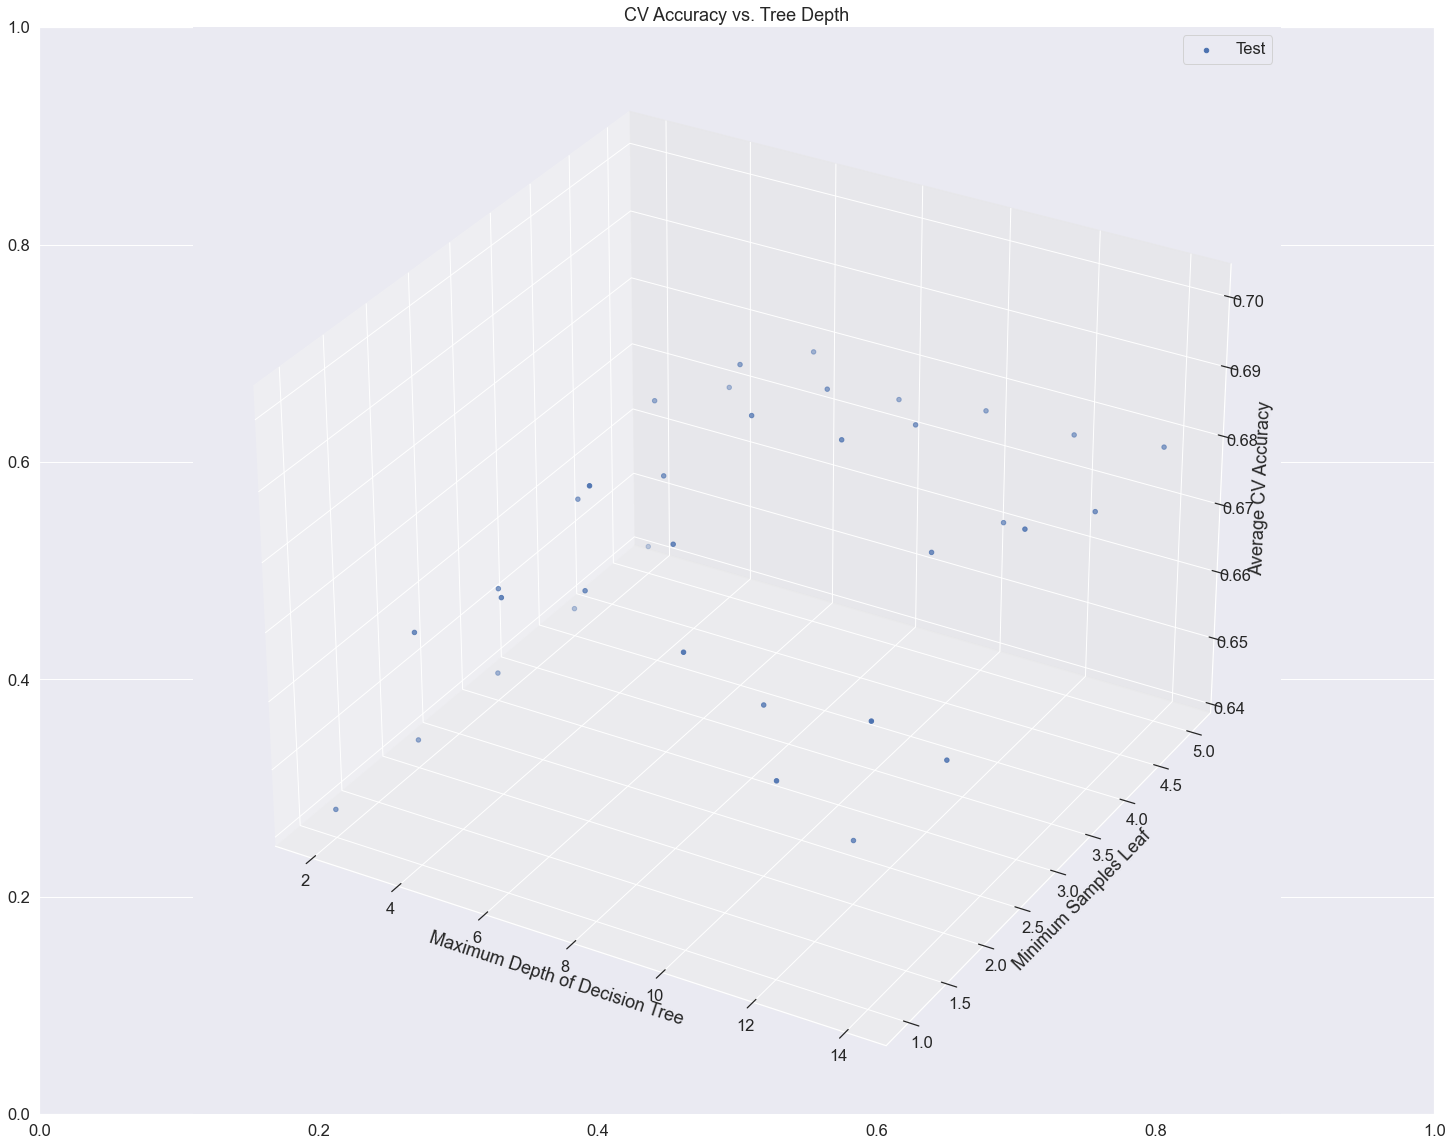

In [92]:
# 3D plot
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(25, 20))
ax = plt.axes(projection='3d')
ax.scatter3D(cv_results['param_max_depth'], cv_results['param_min_samples_leaf'], cv_results['mean_test_score'], label='Test')
ax.set_xlabel('Maximum Depth of Decision Tree')
ax.set_ylabel('Minimum Samples Leaf')
ax.set_zlabel('Average CV Accuracy')
ax.set_title('CV Accuracy vs. Tree Depth')
ax.legend(loc='best')
plt.show()

In [124]:
# fitting model with best paramaters
model = cv_model.best_estimator_
model.fit(X_train, Y_train)
yhat = model.predict(X_test)
yhat_train = model.predict(X_train)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test, yhat))

print('Precision: %.2f' % recall_score(Y_test, yhat))


print('Recall: %.2f' % precision_score(Y_test, yhat))


Best maximum depth: 8
Best min samples leaf: 1
Accuracy (train): 0.85
Accuracy (test): 0.65
Precision: 0.58
Recall: 0.62


[Text(0.55859375, 0.9444444444444444, 'Pclass <= 2.5\ngini = 0.478\nsamples = 571\nvalue = [345, 226]\nclass = s'),
 Text(0.25390625, 0.8333333333333334, 'Fare <= 13.646\ngini = 0.493\nsamples = 280\nvalue = [124, 156]\nclass = u'),
 Text(0.0625, 0.7222222222222222, 'Embarked_S <= 0.5\ngini = 0.404\nsamples = 64\nvalue = [46, 18]\nclass = s'),
 Text(0.05113636363636364, 0.6111111111111112, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = u'),
 Text(0.07386363636363637, 0.6111111111111112, 'Age <= 26.5\ngini = 0.383\nsamples = 62\nvalue = [46, 16]\nclass = s'),
 Text(0.045454545454545456, 0.5, 'Fare <= 11.0\ngini = 0.198\nsamples = 18\nvalue = [16, 2]\nclass = s'),
 Text(0.03409090909090909, 0.3888888888888889, 'Age <= 22.0\ngini = 0.408\nsamples = 7\nvalue = [5, 2]\nclass = s'),
 Text(0.022727272727272728, 0.2777777777777778, 'Age <= 17.5\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = s'),
 Text(0.011363636363636364, 0.16666666666666666, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\ncl

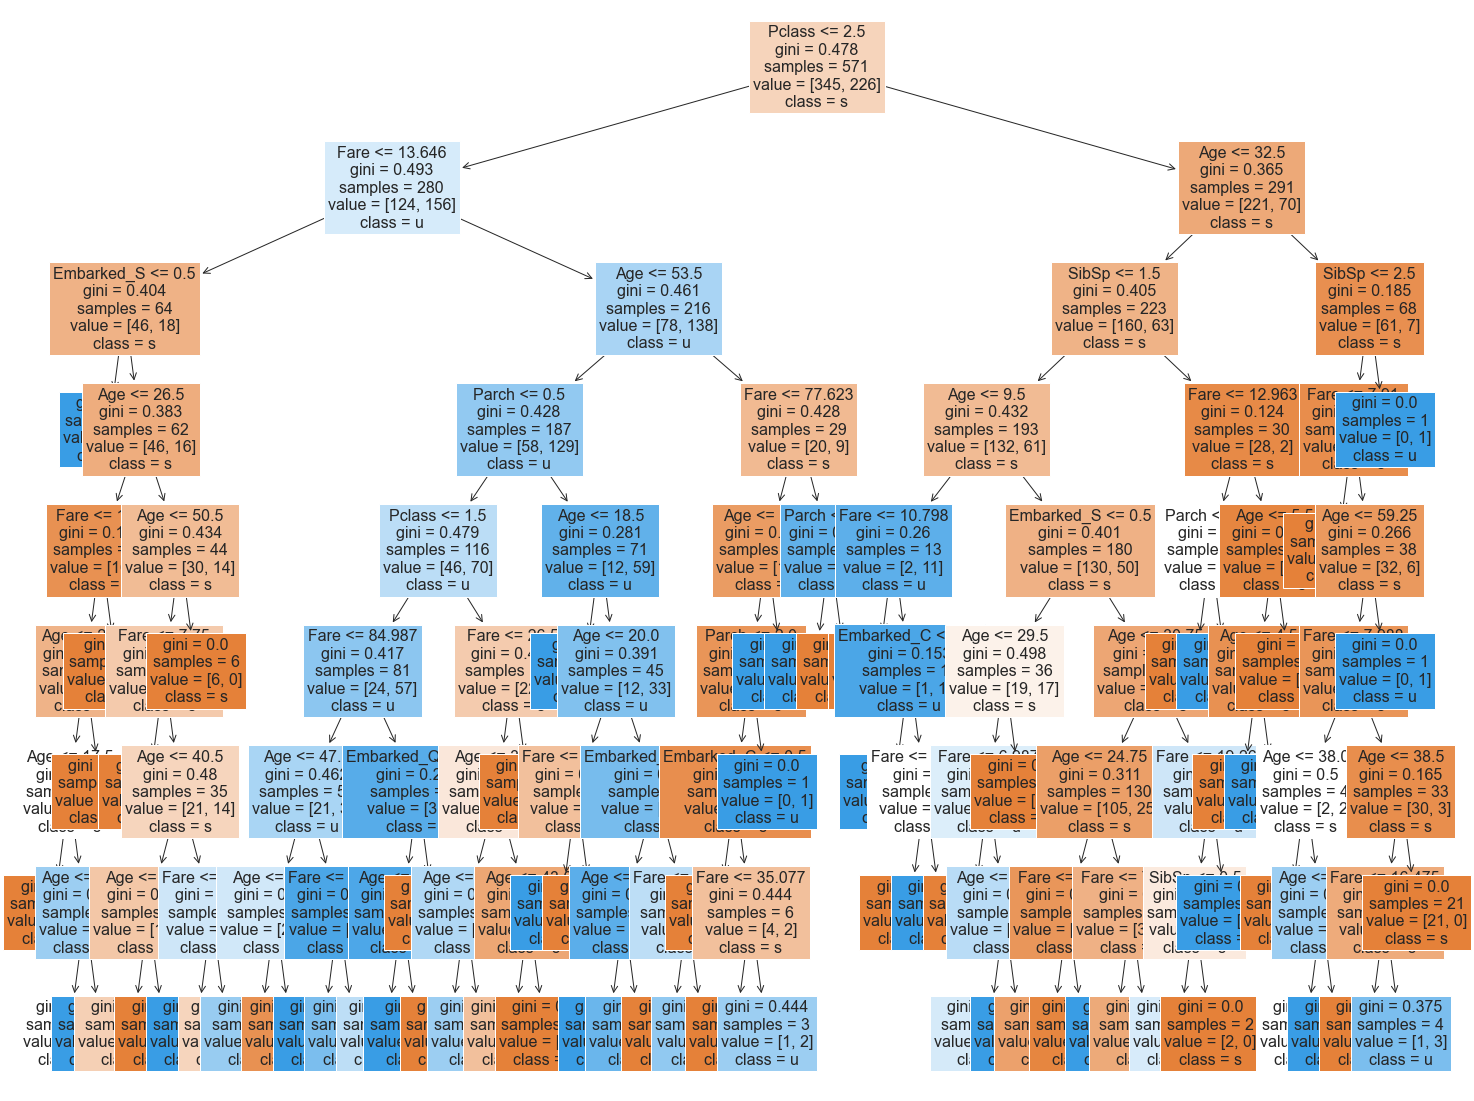

In [125]:
# plotting
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model, 
                   feature_names = X_train.columns,  
                   class_names= 'survived', 
                   filled=True,
                   fontsize=16)

*Your observations here*

### 2.4 Support Vector Machines, for comparison

As a starting point, use the basic [sklearn SVM model](https://scikit-learn.org/stable/modules/svm.html), with the default constant penalization (C=1), to predict survival using the same set of features as above. Report your accuracy on the test and train sets.

Next, use cross-validation to determine a possibly better choice for C. Note that regularization is inversely proportional to the value of C in sklearn, i.e. the higher value you choose for C the less you regularize. Plot a graph with C on the x-axis and cross-validated accuracy on the y-axis.
    
    
How does the test performance with SVM for your best choice of C compare to the decision tree from 2.3?

In [140]:
from sklearn import svm

# SVM model with default params
clf = svm.SVC(C=1)
clf.fit(X_train, Y_train)
yhat_train = clf.predict(X_train)
yhat_test = clf.predict(X_test)
print('Accuracy (train): %.2f' % accuracy_score(Y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test, yhat_test))


Accuracy (train): 0.68
Accuracy (test): 0.65


In [141]:
# SVM model using cross-val to tune C param
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'C':[0.0001,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
cv_model = GridSearchCV(clf, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, Y_train)
cv_results = pd.DataFrame(cv_model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.011632      0.003849         0.008546        0.001867  0.0001   
1       0.007252      0.000101         0.006330        0.000062   0.001   
2       0.007447      0.000051         0.006361        0.000085    0.01   
3       0.007307      0.000017         0.006141        0.000051     0.1   
4       0.007156      0.000059         0.005902        0.000071     0.2   

          params  split0_test_score  split1_test_score  split2_test_score  \
0  {'C': 0.0001}           0.612565           0.605263           0.594737   
1   {'C': 0.001}           0.612565           0.605263           0.594737   
2    {'C': 0.01}           0.612565           0.605263           0.594737   
3     {'C': 0.1}           0.643979           0.700000           0.673684   
4     {'C': 0.2}           0.643979           0.705263           0.694737   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.604188        0.007318               11            0.600000   
1         0.604188        0.007318               11            0.600000   
2         0.604188        0.007318               11            0.600000   
3         0.672554        0.022884               10            0.673684   
4         0.681326        0.026756                2            0.697368   

   split1_train_score  split2_train_score  mean_train_score  std_train_score  
0            0.603675            0.608924          0.604199         0.003662  
1            0.603675            0.608924          0.604199         0.003662  
2            0.603675            0.608924          0.604199         0.003662  
3            0.669291            0.666667          0.669881         0.002895  
4            0.671916            0.677165          0.682150         0.010972

In [146]:
# best model
print(cv_model.best_estimator_)


SVC(C=0.4)


In [154]:
# cross validated performance
print(cv_results[(cv_results.param_C == .4)][['mean_test_score']])

   mean_test_score
6         0.681326


In [161]:
# fitting model with best paramaters
svm_best = cv_model.best_estimator_
svm_best.fit(X_train, Y_train)
yhat = model.predict(X_test)
yhat_train = model.predict(X_train)

print('Best C: %.2f' % cv_model.best_params_['C'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test, yhat))

print('Precision: %.2f' % recall_score(Y_test, yhat))


print('Recall: %.2f' % precision_score(Y_test, yhat))


Best C: 0.40
Accuracy (train): 0.68
Accuracy (test): 0.65
Precision: 0.38
Recall: 0.71


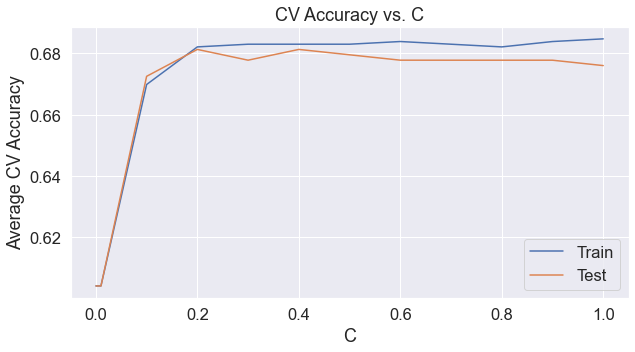

In [162]:
# Plot CV accuracy as a function of C
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(cv_results['param_C'], cv_results['mean_train_score'], label='Train')
ax.plot(cv_results['param_C'], cv_results['mean_test_score'], label='Test')
ax.set_xlabel('C')
ax.set_ylabel('Average CV Accuracy')
ax.set_title('CV Accuracy vs. C')
ax.legend(loc='best')
plt.show()

SVM Accuracy (test): 0.65
Decision Tree Accuracy (test): 0.65

Our two models have the same test accuracy.

### 2.5 Missing Data, Imputation and Feature Engineering

Have you been paying close attention to your features? If not, now is a good time to start. Perform analysis that allows you to answer the following questions:
* Recall from part 1 that some features have missing data. Which features have missingness?
* Try running the decision tree and SVM models from part 1 using all columns, including those with missing data. What happens?
* Use one of the methods we discussed in class to impute missing values for each feature. For each feature with missingness, describe the method used and why it is appropriate to the feature.
* Find a way to engineer meaningful features from the "Name" and/or "Cabin" fields in the data.
* Rerun your decision tree and SVM on the new dataset with imputed missing values and the new features, including re-selecting hyperparameters via cross validation. What do you notice?

In [276]:
# inspecting null values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Embarked_S       0
Embarked_C       0
Embarked_Q       0
dtype: int64

Our variables Age, Cabin, and Embarked have missing values

In [280]:
#trying to run models with untouched variables
X_new = df.drop(['Survived', 'Name', 'Ticket', 'Cabin', 'Embarked'],axis=1)
model.fit(X_new,df['Survived'])
best_svm.fit(X_new,df['Survived'])


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

Our models will not run because of NaN values

In [191]:
df_new = df.copy()

In [192]:
# For Age, I will impute mean value
df_new['Age'].fillna(df_new['Age'].mean(), inplace=True)
print(df_new['Age'].values)

[22.         38.         26.         35.         35.         29.69911765
 54.          2.         27.         14.          4.         58.
 20.         39.         14.         55.          2.         29.69911765
 31.         29.69911765 35.         34.         15.         28.
  8.         38.         29.69911765 19.         29.69911765 29.69911765
 40.         29.69911765 29.69911765 66.         28.         42.
 29.69911765 21.         18.         14.         40.         27.
 29.69911765  3.         19.         29.69911765 29.69911765 29.69911765
 29.69911765 18.          7.         21.         49.         29.
 65.         29.69911765 21.         28.5         5.         11.
 22.         38.         45.          4.         29.69911765 29.69911765
 29.         19.         17.         26.         32.         16.
 21.         26.         32.         25.         29.69911765 29.69911765
  0.83       30.         22.         29.         29.69911765 28.
 17.         33.         16.         29.69

In [193]:
# For Embarked, I will impute most common value
df_new['Embarked'].fillna(df_new['Embarked'].mode())

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [194]:
# For Cabin, I will assign values 1-7 based on the first letter of their cabin assignment
# and I will code 0 for those without a cabin assignment (NA values) and T will be grouped with G
df_new['Cabin'] = df_new.Cabin.str[:1]
df_new.loc[df_new['Cabin'] == 'A', 'Cabin'] = 1
df_new.loc[df_new['Cabin'] == 'B', 'Cabin'] = 2
df_new.loc[df_new['Cabin'] == 'C', 'Cabin'] = 3
df_new.loc[df_new['Cabin'] == 'D', 'Cabin'] = 4
df_new.loc[df_new['Cabin'] == 'E', 'Cabin'] = 5
df_new.loc[df_new['Cabin'] == 'F', 'Cabin'] = 6
df_new.loc[df_new['Cabin'] == 'G', 'Cabin'] = 7
df_new.loc[df_new['Cabin'] == 'T', 'Cabin'] = 7
df_new['Cabin'].fillna(0, inplace=True)


In [195]:
# For Names, I will take the first portion as an identifier
df_new['Title'] = df_new.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_new.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [196]:
# reassigning titles with dummy variables
df_new.loc[df_new['Title'] == 'Mr', 'Title_Mr'] = 1 
df_new.loc[df_new['Title'] != 'Mr', 'Title_Mr'] = 0 
df_new.loc[df_new['Title'] == 'Miss', 'Title_Miss'] = 1 
df_new.loc[df_new['Title'] != 'Miss', 'Title_Miss'] = 0 
df_new.loc[df_new['Title'] == 'Mrs', 'Title_Mrs'] = 1 
df_new.loc[df_new['Title'] != 'Mrs', 'Title_Mrs'] = 0 
df_new.loc[df_new['Title'] == 'Master', 'Title_Master'] = 1 
df_new.loc[df_new['Title'] != 'Master', 'Title_Master'] = 0 
df_new.loc[~df_new['Title'].isin(['Mr','Miss','Mrs','Master']), 'Title_Other'] = 1 
df_new.loc[df_new['Title'].isin(['Mr','Miss','Mrs','Master']), 'Title_Other'] = 0 

In [197]:
# dropping unecessary columns
df_new = df_new.drop(['Name', 'Sex', 'Embarked', 'Title', 'Ticket'], axis=1)
print(df_new.head())
print(df_new.columns)


   PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Cabin  \
0            1         0       3  22.0      1      0   7.2500      0   
1            2         1       1  38.0      1      0  71.2833      3   
2            3         1       3  26.0      0      0   7.9250      0   
3            4         1       1  35.0      1      0  53.1000      3   
4            5         0       3  35.0      0      0   8.0500      0   

   Embarked_S  Embarked_C  Embarked_Q  Title_Mr  Title_Miss  Title_Mrs  \
0         1.0         0.0         0.0       1.0         0.0        0.0   
1         0.0         1.0         0.0       0.0         0.0        1.0   
2         1.0         0.0         0.0       0.0         1.0        0.0   
3         1.0         0.0         0.0       0.0         0.0        1.0   
4         1.0         0.0         0.0       1.0         0.0        0.0   

   Title_Master  Title_Other  
0           0.0          0.0  
1           0.0          0.0  
2           0.0          0.0 

In [198]:
# ensuring there are no more null values
df_new.isnull().sum()

PassengerId     0
Survived        0
Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin           0
Embarked_S      0
Embarked_C      0
Embarked_Q      0
Title_Mr        0
Title_Miss      0
Title_Mrs       0
Title_Master    0
Title_Other     0
dtype: int64

In [199]:
#splitting set into training and testing data
training_data, testing_data = train_test_split(df_new, test_size=0.2, random_state=0)
X_train_new = training_data[['Pclass', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked_S', 'Embarked_C', 'Embarked_Q',
       'Title_Mr', 'Title_Miss', 'Title_Mrs', 'Title_Master', 'Title_Other']]
Y_train_new = training_data['Survived']
X_test_new = testing_data[['Pclass', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked_S', 'Embarked_C', 'Embarked_Q',
       'Title_Mr', 'Title_Miss', 'Title_Mrs', 'Title_Master', 'Title_Other']]
Y_test_new = testing_data['Survived']

In [200]:
# standardizing
X_train_new = standardize(X_train_new)
X_test_new = standardize(X_test_new)

In [201]:
# rerunning Decision Tree
tree_model = sklearn.tree.DecisionTreeClassifier(random_state=0)

cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8, 10, 12, 14], 'min_samples_leaf':[1,2,3,4,5]}
cv_model = GridSearchCV(tree_model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train_new, Y_train_new)
cv_results = pd.DataFrame(cv_model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.003680      0.001912         0.001567        0.000408   
1       0.001981      0.000285         0.001211        0.000261   
2       0.001597      0.000025         0.000941        0.000010   
3       0.001611      0.000036         0.000953        0.000043   
4       0.001512      0.000057         0.000856        0.000015   

  param_max_depth param_min_samples_leaf  \
0               2                      1   
1               2                      2   
2               2                      3   
3               2                      4   
4               2                      5   

                                    params  split0_test_score  \
0  {'max_depth': 2, 'min_samples_leaf': 1}           0.802521   
1  {'max_depth': 2, 'min_samples_leaf': 2}           0.802521   
2  {'max_depth': 2, 'min_samples_leaf': 3}           0.802521   
3  {'max_depth': 2, 'min_samples_leaf': 4}           0.802521   
4  {'max_depth': 2, 'min_samples_leaf': 5}           0.802521   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.751055           0.751055          0.76821        0.024261   
1           0.751055           0.751055          0.76821        0.024261   
2           0.751055           0.751055          0.76821        0.024261   
3           0.751055           0.751055          0.76821        0.024261   
4           0.751055           0.751055          0.76821        0.024261   

   rank_test_score  split0_train_score  split1_train_score  \
0               27              0.7827            0.808421   
1               27              0.7827            0.808421   
2               27              0.7827            0.808421   
3               27              0.7827            0.808421   
4               27              0.7827            0.808421   

   split2_train_score  mean_train_score  std_train_score  
0            0.808421          0.799848         0.012125  
1            0.808421          0.799848         0.012125  
2            0.808421          0.799848         0.012125  
3            0.808421          0.799848         0.012125  
4            0.808421          0.799848         0.012125

In [202]:
print(cv_model.best_estimator_)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=0)


In [203]:
print(cv_results[(cv_results.param_min_samples_leaf == 3) & (cv_results.param_max_depth == 4)][['mean_test_score']])


   mean_test_score
7         0.820167


In [204]:
# fitting model with best paramaters
model = cv_model.best_estimator_
model.fit(X_train_new, Y_train_new)
yhat = model.predict(X_test_new)
yhat_train = model.predict(X_train_new)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train_new, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test_new, yhat))

print('Precision: %.2f' % recall_score(Y_test_new, yhat))


print('Recall: %.2f' % precision_score(Y_test_new, yhat))


Best maximum depth: 4
Best min samples leaf: 3
Accuracy (train): 0.85
Accuracy (test): 0.80
Precision: 0.67
Recall: 0.79


[Text(0.5, 0.9, 'Title_Mr <= -0.18\ngini = 0.473\nsamples = 712\nvalue = [439, 273]\nclass = s'),
 Text(0.25, 0.7, 'Pclass <= 0.219\ngini = 0.412\nsamples = 293\nvalue = [85, 208]\nclass = u'),
 Text(0.125, 0.5, 'Title_Other <= 3.119\ngini = 0.176\nsamples = 154\nvalue = [15, 139]\nclass = u'),
 Text(0.0625, 0.3, 'Fare <= -0.06\ngini = 0.11\nsamples = 137\nvalue = [8, 129]\nclass = u'),
 Text(0.03125, 0.1, 'gini = 0.191\nsamples = 56\nvalue = [6, 50]\nclass = u'),
 Text(0.09375, 0.1, 'gini = 0.048\nsamples = 81\nvalue = [2, 79]\nclass = u'),
 Text(0.1875, 0.3, 'Fare <= -0.067\ngini = 0.484\nsamples = 17\nvalue = [7, 10]\nclass = u'),
 Text(0.15625, 0.1, 'gini = 0.278\nsamples = 6\nvalue = [5, 1]\nclass = s'),
 Text(0.21875, 0.1, 'gini = 0.298\nsamples = 11\nvalue = [2, 9]\nclass = u'),
 Text(0.375, 0.5, 'Fare <= -0.17\ngini = 0.5\nsamples = 139\nvalue = [70, 69]\nclass = s'),
 Text(0.3125, 0.3, 'Age <= 0.009\ngini = 0.459\nsamples = 101\nvalue = [36, 65]\nclass = u'),
 Text(0.28125, 0.

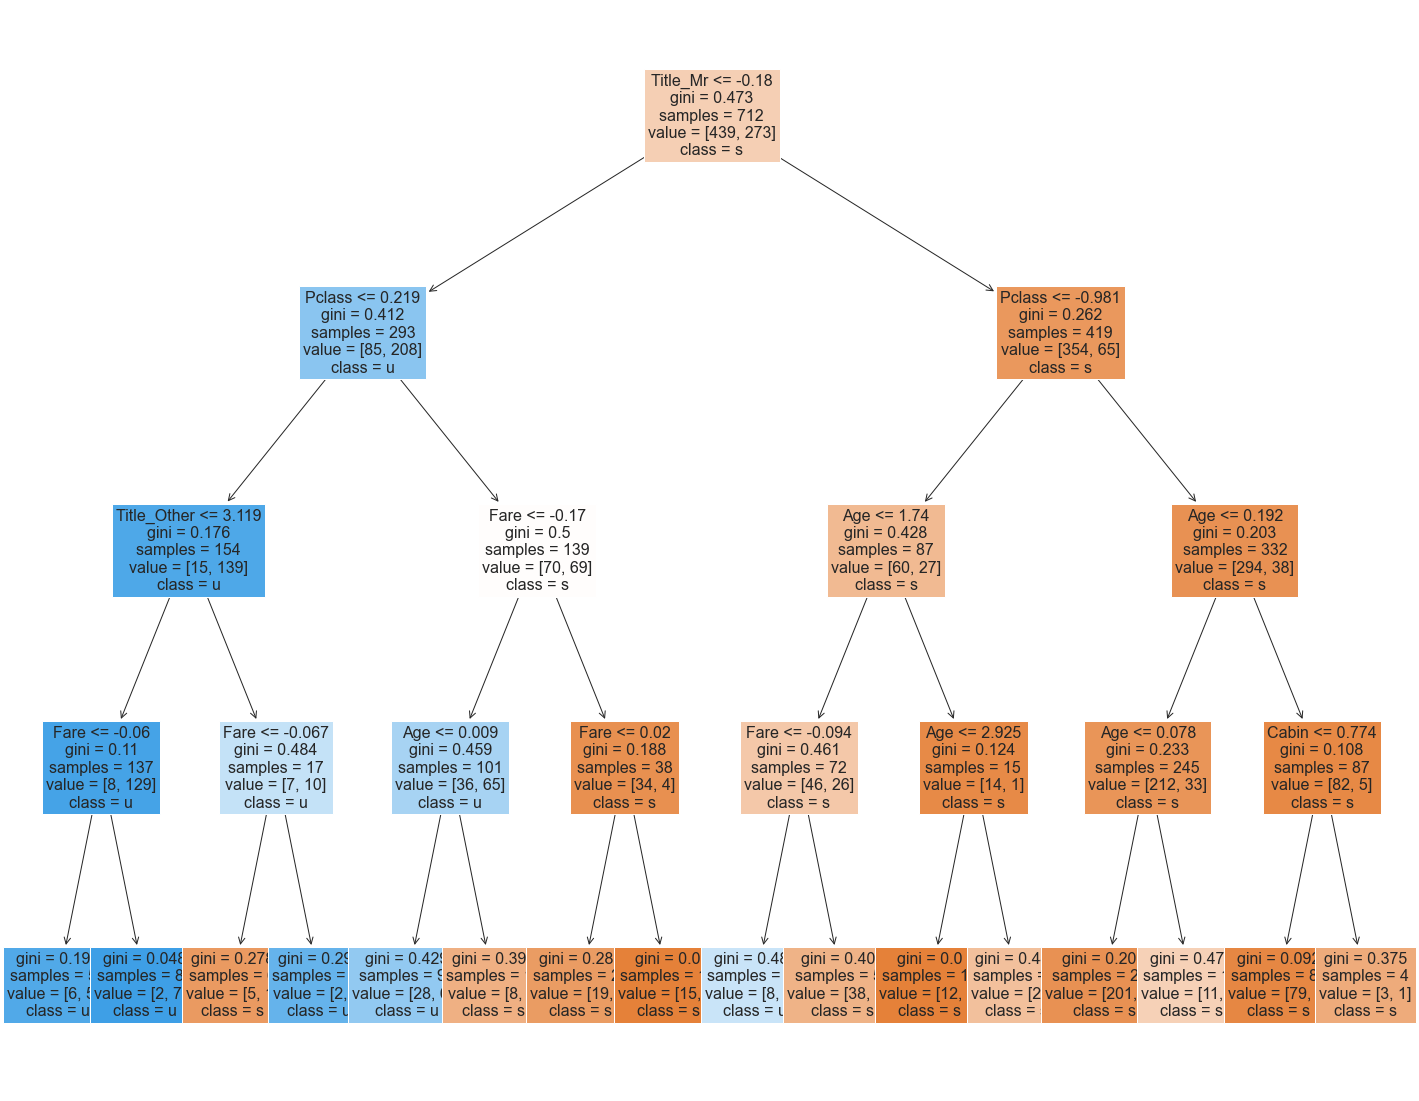

In [206]:
best_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=0)
best_tree.fit(X_train_new,Y_train_new)
fig = plt.figure(figsize=(25,20))
tree.plot_tree(best_tree, 
                   feature_names = X_train_new.columns,  
                   class_names= 'survived', 
                   filled=True,
                   fontsize=16)

After imputing the data and feature engineering, we find that our mdoel improves and that our most significant featurues change.

In [207]:
# rerunning SVM
svm_model = svm.SVC()
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'C':[0.0001,.001,.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
cv_model = GridSearchCV(svm_model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train_new, Y_train_new)
cv_results = pd.DataFrame(cv_model.cv_results_)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.015462      0.005075         0.010964        0.001914  0.0001   
1       0.011104      0.000256         0.009359        0.000273   0.001   
2       0.010913      0.000153         0.009310        0.000139    0.01   
3       0.010132      0.000271         0.008519        0.000198     0.1   
4       0.009397      0.000295         0.007628        0.000163     0.2   

          params  split0_test_score  split1_test_score  split2_test_score  \
0  {'C': 0.0001}           0.634454           0.611814           0.603376   
1   {'C': 0.001}           0.634454           0.611814           0.603376   
2    {'C': 0.01}           0.634454           0.611814           0.603376   
3     {'C': 0.1}           0.806723           0.759494           0.827004   
4     {'C': 0.2}           0.844538           0.780591           0.835443   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0         0.616548        0.013122               11            0.607595   
1         0.616548        0.013122               11            0.607595   
2         0.616548        0.013122               11            0.607595   
3         0.797740        0.028283               10            0.803797   
4         0.820191        0.028246                9            0.814346   

   split1_train_score  split2_train_score  mean_train_score  std_train_score  
0            0.618947            0.623158          0.616567         0.006573  
1            0.618947            0.623158          0.616567         0.006573  
2            0.618947            0.623158          0.616567         0.006573  
3            0.812632            0.812632          0.809687         0.004164  
4            0.848421            0.825263          0.829343         0.014207

In [208]:
print(cv_model.best_estimator_)

SVC(C=0.5)


In [210]:
# cross validated performance
print(cv_results[(cv_results.param_C == .5)][['mean_test_score']])

   mean_test_score
7         0.832837


In [212]:
# fitting model with best paramaters
svm_best = cv_model.best_estimator_
svm_best.fit(X_train_new, Y_train_new)
yhat = model.predict(X_test_new)
yhat_train = model.predict(X_train_new)

print('Best C: %.2f' % cv_model.best_params_['C'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train_new, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test_new, yhat))

print('Precision: %.2f' % recall_score(Y_test_new, yhat))


print('Recall: %.2f' % precision_score(Y_test_new, yhat))


Best C: 0.50
Accuracy (train): 0.85
Accuracy (test): 0.80
Precision: 0.67
Recall: 0.79


After imputing the data and feature engineering, we find that our SVM model also improves.

### 2.6 ROC Curve

For your best decision tree from 2.5, plot the reciever operating characteristic (ROC) curve on the test set data. Report the area under the curve (AUC) score. *Hint*: scikit-learn's built-in predict_proba function may be helpful for this problem.  For each model, identify the point on the ROC curve that is closest to the top-left corner, and identify the associated probability threshold for classification. Place a vertical line on your plot indicating the FPR value at the threshold. Finally, report accuracy on the test set using the threshold you identified. Comparing to the accuracy from 2.5, what do you observe? 

Threshold closest to top-left corner of graph: 0.27 (0.88 TPR, 0.20 FPR)
AUC score: 0.88


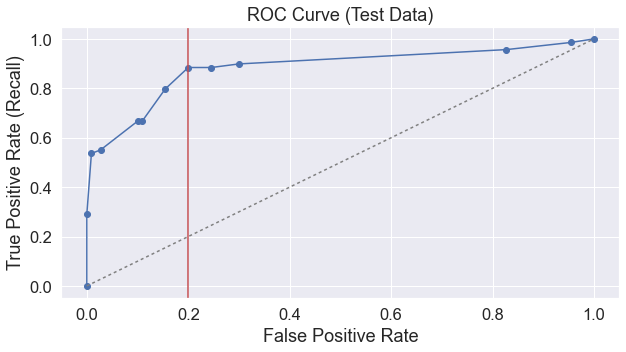

In [224]:
# ROC Curve
yhat_test_proba = best_tree.predict_proba(X_test_new)[:, 1]
fprs, tprs, thresholds = roc_curve(Y_test_new, yhat_test_proba)


# Get "optimal" threshold: the one closest to the top-left corner of the ROC graph
#distances_from_top_left = [np.sqrt(tprs[i]**2 + (1-fprs[i])**2) for i in range(len(tprs))]
best_cutoff = np.argmax(tprs - fprs)
optimal_threshold = thresholds[best_cutoff]
#best_cutoff = np.argmin(distances_from_top_left)
print('Threshold closest to top-left corner of graph: %.2f (%.2f TPR, %.2f FPR)' % 
      (thresholds[best_cutoff], tprs[best_cutoff], fprs[best_cutoff]))

print('AUC score: %.2f' % roc_auc_score(Y_test_new, yhat_test_proba))

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(fprs, tprs)
ax.plot(fprs, tprs)
ax.plot([0, 1], [0, 1], color='grey', dashes=[2, 2])
plt.axvline(x=fprs[best_cutoff], c='r')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curve (Test Data)')
plt.show()

In [219]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score, plot_roc_curve

In [227]:
tp = best_tree.predict_proba(X_test_new)[:,1]
tp[tp >= thresholds[best_cutoff]] = 1
tp[threshold_tree_predictions < thresholds[best_cutoff]] = 0
print("Decision Tree accuracy for optimal threshold (", thresholds[best_cutoff],") is: ",accuracy_score(Y_test_new, tp))

Decision Tree accuracy for optimal threshold ( 0.2727272727272727 ) is:  0.8324022346368715


We see that the accuracy improves from .80 to .83

## Part 3: Many Trees

### 3.1: Random Forest
Use the [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to predict survival on the titanic. Use cross-validation on the training data to choose the best hyper-parameters --- including the maximum depth, number of trees in the forest, and the minimum samples per leaf.
* What hyperparameters did you select with cross-validation? You should use cross-validation to select all of the hyperparameters (i.e. search a grid of hyperparameters), and report the combination that maximizes cross-validated accuracy). You can use fewer cross validation folds than the 10 folds from previous problems, to keep your code from taking too long to run.
* How does the cross-validated performance (average across validation folds) compare to the test performance (using the top-performing, fitted model selected through cross-validation)?
* How does the RF performance compare to the decision tree and SVM from part 2.5?
* Create 3 subplots that show how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis), maximum depth (x-axis), and minimum samples per leaf (x-axis). What do you observe?

In [52]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score

In [229]:
# default RF with no cross val using imputed data
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_new, Y_train_new)
yhat_train = rf.predict(X_train_new)
yhat_test = rf.predict(X_test_new)

print('Accuracy (train): %.2f' % accuracy_score(Y_train_new, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test_new, yhat_test))

print('Precision (train): %.2f' % recall_score(Y_train_new, yhat_train))
print('Precision (test): %.2f' % recall_score(Y_test_new, yhat_test))

print('Recall (train): %.2f' % precision_score(Y_train_new, yhat_train))
print('Recall (test): %.2f' % precision_score(Y_test_new, yhat_test))

Accuracy (train): 0.99
Accuracy (test): 0.80
Precision (train): 0.98
Precision (test): 0.72
Recall (train): 0.99
Recall (test): 0.76


In [230]:
# Tune hyperparameters: max_depth, n_estimators, min_samples_split, min_samples_leaf using non-imputed data
model = RandomForestClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[int(x) for x in np.linspace(3, 30, num = 5)], 'n_estimators':[int(x) for x in np.linspace(start = 20, stop = 250, num = 8)], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,4] }
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, Y_train)
model = cv_model.best_estimator_
model.fit(X_train, Y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])
print('Best min samples split: %i' % cv_model.best_params_['min_samples_split'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(Y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(Y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(Y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(Y_test, yhat_test))

Best maximum depth: 9
Best number of estimators: 250
Best min samples split: 10
Best min samples leaf: 2
Accuracy (train): 0.82
Accuracy (test): 0.76
Precision (train): 0.70
Precision (test): 0.66
Recall (train): 0.82
Recall (test): 0.78


In [232]:
rf_result_grid = pd.DataFrame(cv_model.cv_results_)
rf_result_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.021814      0.005415         0.002688        0.000650   
1         0.034139      0.000038         0.003595        0.000027   
2         0.054840      0.000136         0.005291        0.000041   
3         0.075469      0.000036         0.006962        0.000026   
4         0.096328      0.000106         0.008754        0.000165   
..             ...           ...              ...             ...   
355       0.082043      0.000245         0.007792        0.000077   
356       0.104843      0.000256         0.009706        0.000053   
357       0.126819      0.000023         0.011587        0.000068   
358       0.149377      0.000080         0.013631        0.000119   
359       0.171774      0.000255         0.015468        0.000112   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
0                 3                      1                       2   
1                 3                      1                       2   
2                 3                      1                       2   
3                 3                      1                       2   
4                 3                      1                       2   
..              ...                    ...                     ...   
355              30                      4                      10   
356              30                      4                      10   
357              30                      4                      10   
358              30                      4                      10   
359              30                      4                      10   

    param_n_estimators                                             params  \
0                   20  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
1                   52  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
2                   85  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
3                  118  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
4                  151  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
..                 ...                                                ...   
355                118  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
356                151  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
357                184  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
358                217  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
359                250  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   

     split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0             0.717277           0.684211           0.763158         0.721549   
1             0.732984           0.678947           0.784211         0.732047   
2             0.727749           0.678947           0.778947         0.728548   
3             0.732984           0.684211           0.768421         0.728539   
4             0.727749           0.678947           0.757895         0.721530   
..                 ...                ...                ...              ...   
355           0.722513           0.694737           0.757895         0.725048   
356           0.717277           0.700000           0.752632         0.723303   
357           0.717277           0.705263           0.752632         0.725057   
358           0.722513           0.710526           0.757895         0.730311   
359           0.722513           0.705263           0.757895         0.728557   

     std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0          0.032371              185            0.757895            0.755906   
1          0.042979               27            0.757895            0.766404   
2          0.040829               52            0.760526            0.766404   
3          0.034522               57            0.760526            0.761155   
4          0.032529              188 

In [233]:
optimal_idx = np.argmin(rf_result_grid.rank_test_score)
print("Accuracy best performing model (cross-validated): ",rf_result_grid.mean_test_score[optimal_idx])
print("Params best performing model: ",rf_result_grid.params[optimal_idx])

Accuracy best performing model (cross-validated):  0.7390833103701663
Params best performing model:  {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 250}


cross-validated performance: 0.76
Test Performance:  0.7390833103701663

We can see that the average cross-validated performance performs better than the test performance.

Create 3 subplots that show how cross-validated performance (y-axis) relates to the number of trees in the forest (x-axis), maximum depth (x-axis), and minimum samples per leaf (x-axis). What do you observe?

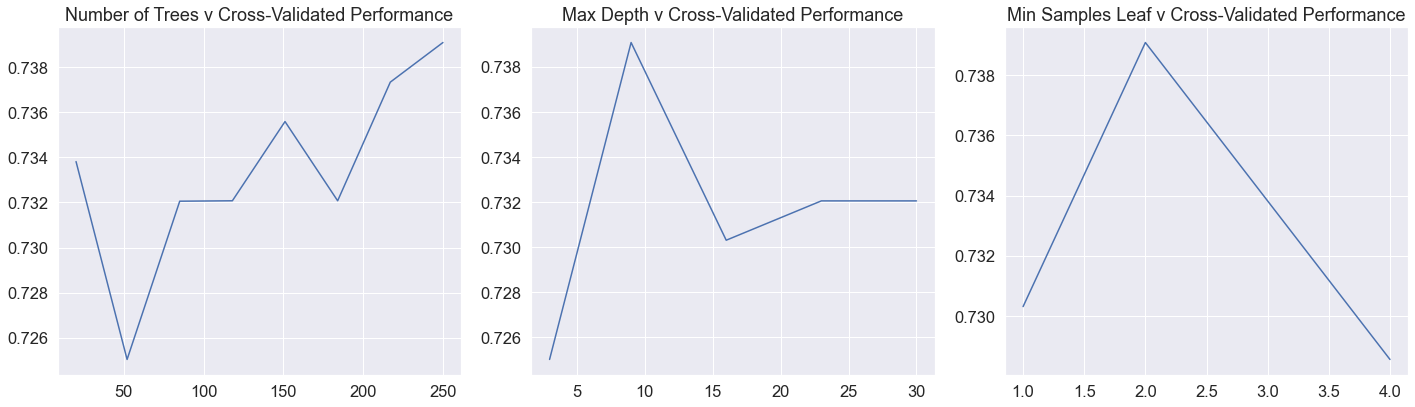

In [234]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax = ax.flatten()

numtrees = rf_result_grid[(rf_result_grid.param_min_samples_leaf == 2) & (rf_result_grid.param_min_samples_split == 10) & (rf_result_grid.param_max_depth == 9)][['mean_test_score','param_n_estimators']]
depth = rf_result_grid[(rf_result_grid.param_min_samples_leaf == 2) & (rf_result_grid.param_min_samples_split == 10) & (rf_result_grid.param_n_estimators == 250)][['mean_test_score','param_max_depth']]
minsamplesleaf = rf_result_grid[(rf_result_grid.param_n_estimators == 250) & (rf_result_grid.param_min_samples_split == 10) & (rf_result_grid.param_max_depth == 9)][['mean_test_score','param_min_samples_leaf']]


ax[0].plot(numtrees.param_n_estimators,numtrees.mean_test_score)
ax[1].plot(depth.param_max_depth,depth.mean_test_score)
ax[2].plot(minsamplesleaf.param_min_samples_leaf,minsamplesleaf.mean_test_score)

ax[0].set_title('Number of Trees v Cross-Validated Performance')
ax[1].set_title('Max Depth v Cross-Validated Performance')
ax[2].set_title('Min Samples Leaf v Cross-Validated Performance')
plt.tight_layout() 
plt.show()

We can see that each value chosen appears to be the peak of cross-val performance, as it should be. We can see in the first graph, the performance appears to increase as the number of trees increases. We may see a different optimal value if we were to expand our range, since we limited our value at 250 here.

In [235]:
# Tune hyperparameters: max_depth, n_estimators, min_samples_split, min_samples_leaf using imputed data
model = RandomForestClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[int(x) for x in np.linspace(3, 30, num = 5)], 'n_estimators':[int(x) for x in np.linspace(start = 20, stop = 250, num = 8)], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,4] }
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train_new, Y_train_new)
model = cv_model.best_estimator_
model.fit(X_train_new, Y_train_new)
yhat_train = model.predict(X_train_new)
yhat_test = model.predict(X_test_new)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])
print('Best min samples split: %i' % cv_model.best_params_['min_samples_split'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train_new, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test_new, yhat_test))

print('Precision (train): %.2f' % recall_score(Y_train_new, yhat_train))
print('Precision (test): %.2f' % recall_score(Y_test_new, yhat_test))

print('Recall (train): %.2f' % precision_score(Y_train_new, yhat_train))
print('Recall (test): %.2f' % precision_score(Y_test_new, yhat_test))

Best maximum depth: 9
Best number of estimators: 52
Best min samples split: 5
Best min samples leaf: 2
Accuracy (train): 0.88
Accuracy (test): 0.82
Precision (train): 0.78
Precision (test): 0.72
Recall (train): 0.90
Recall (test): 0.78


In [236]:
rf_result_grid = pd.DataFrame(cv_model.cv_results_)
rf_result_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.022148      0.005703         0.002795        0.000888   
1         0.034924      0.000022         0.003681        0.000017   
2         0.055930      0.000038         0.005442        0.000010   
3         0.077289      0.000119         0.007246        0.000015   
4         0.099351      0.000380         0.009113        0.000143   
..             ...           ...              ...             ...   
355       0.084515      0.000219         0.008131        0.000015   
356       0.107804      0.000394         0.010118        0.000004   
357       0.131632      0.000329         0.012254        0.000065   
358       0.154423      0.000497         0.014213        0.000004   
359       0.178039      0.000602         0.016499        0.000247   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
0                 3                      1                       2   
1                 3                      1                       2   
2                 3                      1                       2   
3                 3                      1                       2   
4                 3                      1                       2   
..              ...                    ...                     ...   
355              30                      4                      10   
356              30                      4                      10   
357              30                      4                      10   
358              30                      4                      10   
359              30                      4                      10   

    param_n_estimators                                             params  \
0                   20  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
1                   52  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
2                   85  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
3                  118  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
4                  151  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
..                 ...                                                ...   
355                118  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
356                151  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
357                184  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
358                217  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
359                250  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   

     split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0             0.777311           0.831224           0.818565         0.809033   
1             0.768908           0.831224           0.843882         0.814671   
2             0.773109           0.822785           0.839662         0.811852   
3             0.773109           0.822785           0.839662         0.811852   
4             0.773109           0.827004           0.852321         0.817478   
..                 ...                ...                ...              ...   
355           0.777311           0.848101           0.843882         0.823098   
356           0.773109           0.848101           0.848101         0.823104   
357           0.773109           0.852321           0.848101         0.824510   
358           0.777311           0.852321           0.848101         0.825911   
359           0.777311           0.848101           0.843882         0.823098   

     std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0          0.023019              300            0.864979            0.821053   
1          0.032770              185            0.858650            0.816842   
2          0.028249              274            0.862869            0.818947   
3          0.028249              274            0.854430            0.818947   
4          0.033032              115 

In [237]:
optimal_idx = np.argmin(rf_result_grid.rank_test_score)
print("Accuracy best performing model (cross-validated): ",rf_result_grid.mean_test_score[optimal_idx])
print("Params best performing model: ",rf_result_grid.params[optimal_idx])

Accuracy best performing model (cross-validated):  0.8259109550993394
Params best performing model:  {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 52}


cross-validated performance: 0.88
Test Performance:  0.8259109550993394

We can see that the average cross-validated performance performs better than the test performance.

Decision Tree accuracy: .8
SVM accuracy: .8
RF accuracy: .826

We can see that random forest performs better than our Decision Tree model and our SVM model.

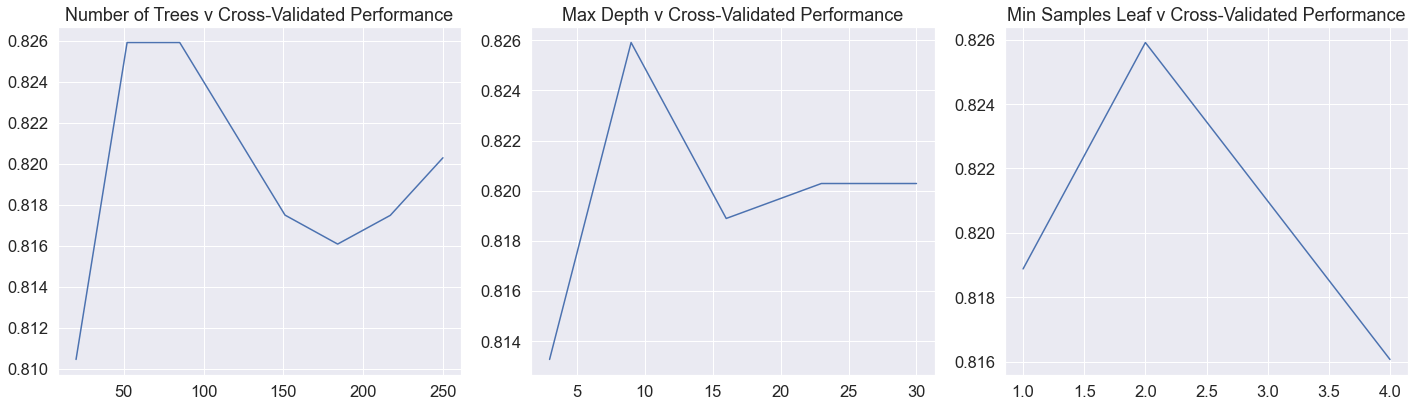

In [239]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax = ax.flatten()

numtrees = rf_result_grid[(rf_result_grid.param_min_samples_leaf == 2) & (rf_result_grid.param_min_samples_split == 5) & (rf_result_grid.param_max_depth == 9)][['mean_test_score','param_n_estimators']]
depth = rf_result_grid[(rf_result_grid.param_min_samples_leaf == 2) & (rf_result_grid.param_min_samples_split == 5) & (rf_result_grid.param_n_estimators == 52)][['mean_test_score','param_max_depth']]
minsamplesleaf = rf_result_grid[(rf_result_grid.param_n_estimators == 52) & (rf_result_grid.param_min_samples_split == 5) & (rf_result_grid.param_max_depth == 9)][['mean_test_score','param_min_samples_leaf']]


ax[0].plot(numtrees.param_n_estimators,numtrees.mean_test_score)
ax[1].plot(depth.param_max_depth,depth.mean_test_score)
ax[2].plot(minsamplesleaf.param_min_samples_leaf,minsamplesleaf.mean_test_score)

ax[0].set_title('Number of Trees v Cross-Validated Performance')
ax[1].set_title('Max Depth v Cross-Validated Performance')
ax[2].set_title('Min Samples Leaf v Cross-Validated Performance')
plt.tight_layout() 
plt.show()

We can see that each value chosen appears to be the peak of cross-val performance, as it should be.

*Your observations here*

### 3.2: Gradient Boosting

Use the [Gradient Boosting classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to predict survival on the Titanic. Tune your hyperparameters with cross validation. Again, you should tune more parameteres than just `max_depth`.
* How does the GBM performance compare to the other models?
* Create a figure showing the feature importances in your final model (with properly tuned hyperparameters)


In [240]:
from sklearn.ensemble import GradientBoostingClassifier

In [241]:
# default params gradient boosting on non-imputed data
gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, Y_train)
yhat_train = gbc.predict(X_train)
yhat_test = gbc.predict(X_test)

print('Accuracy (train): %.2f' % accuracy_score(Y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(Y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(Y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(Y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(Y_test, yhat_test))

Accuracy (train): 0.83
Accuracy (test): 0.73
Precision (train): 0.69
Precision (test): 0.66
Recall (train): 0.84
Recall (test): 0.71


In [242]:
# Tune hyperparameters: max_depth, n_estimators, min_samples_split, min_samples_leaf on non-imputed data
gbc = GradientBoostingClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[int(x) for x in np.linspace(3, 30, num = 5)], 'n_estimators':[int(x) for x in np.linspace(start = 20, stop = 250, num = 8)], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,4] }
cv_model = GridSearchCV(gbc, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train, Y_train)
gbc = cv_model.best_estimator_
gbc.fit(X_train, Y_train)
yhat_train = gbc.predict(X_train)
yhat_test = gbc.predict(X_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])
print('Best min samples split: %i' % cv_model.best_params_['min_samples_split'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(Y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(Y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(Y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(Y_test, yhat_test))

Best maximum depth: 3
Best number of estimators: 52
Best min samples split: 2
Best min samples leaf: 2
Accuracy (train): 0.80
Accuracy (test): 0.74
Precision (train): 0.63
Precision (test): 0.66
Recall (train): 0.81
Recall (test): 0.74


In [243]:
rf_result_grid = pd.DataFrame(cv_model.cv_results_)
rf_result_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.009462      0.000567         0.000937        0.000114   
1         0.020878      0.000135         0.000959        0.000028   
2         0.032855      0.000299         0.001005        0.000009   
3         0.045009      0.000458         0.001069        0.000013   
4         0.057144      0.000377         0.001161        0.000051   
..             ...           ...              ...             ...   
355       0.191056      0.005571         0.002279        0.000106   
356       0.245331      0.006708         0.002694        0.000156   
357       0.303009      0.009756         0.003230        0.000211   
358       0.357710      0.011409         0.003826        0.000071   
359       0.412503      0.010933         0.004098        0.000118   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
0                 3                      1                       2   
1                 3                      1                       2   
2                 3                      1                       2   
3                 3                      1                       2   
4                 3                      1                       2   
..              ...                    ...                     ...   
355              30                      4                      10   
356              30                      4                      10   
357              30                      4                      10   
358              30                      4                      10   
359              30                      4                      10   

    param_n_estimators                                             params  \
0                   20  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
1                   52  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
2                   85  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
3                  118  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
4                  151  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
..                 ...                                                ...   
355                118  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
356                151  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
357                184  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
358                217  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
359                250  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   

     split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0             0.717277           0.700000           0.768421         0.728566   
1             0.732984           0.705263           0.747368         0.728539   
2             0.701571           0.700000           0.731579         0.711050   
3             0.727749           0.694737           0.721053         0.714513   
4             0.717277           0.689474           0.731579         0.712777   
..                 ...                ...                ...              ...   
355           0.638743           0.652632           0.705263         0.665546   
356           0.643979           0.647368           0.705263         0.665537   
357           0.670157           0.631579           0.700000         0.667245   
358           0.659686           0.647368           0.700000         0.669018   
359           0.659686           0.657895           0.700000         0.672527   

     std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0          0.029051                7            0.784211            0.792651   
1          0.017474               13            0.818421            0.829396   
2          0.014530               35            0.868421            0.863517   
3          0.014248               29            0.892105            0.881890   
4          0.017482               33 

In [244]:
optimal_idx = np.argmin(rf_result_grid.rank_test_score)
print("Accuracy best performing model (cross-validated): ",rf_result_grid.mean_test_score[optimal_idx])
print("Params best performing model: ",rf_result_grid.params[optimal_idx])

Accuracy best performing model (cross-validated):  0.7337742261412693
Params best performing model:  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 52}


In [245]:
# Get feature importances
importances = gbc.feature_importances_
#std = np.std([abc.feature_importances_ for abc in gbc.estimators_], axis=0)
importances = pd.DataFrame([X_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=True)

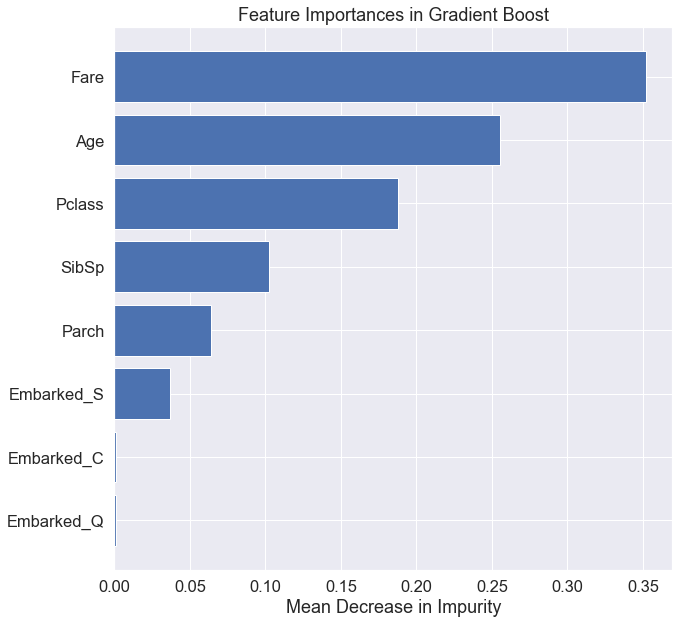

In [246]:
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.barh(importances['Feature'], importances['Importance'])#, yerr=std)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_title('Feature Importances in Gradient Boost')
plt.show()

In [247]:
# Tune hyperparameters: max_depth, n_estimators, min_samples_split, min_samples_leaf on imputed data
gbc = GradientBoostingClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=0)
params = {'max_depth':[int(x) for x in np.linspace(3, 30, num = 5)], 'n_estimators':[int(x) for x in np.linspace(start = 20, stop = 250, num = 8)], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,4] }
cv_model = GridSearchCV(gbc, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(X_train_new, Y_train_new)
gbc = cv_model.best_estimator_
gbc.fit(X_train_new, Y_train_new)
yhat_train = gbc.predict(X_train_new)
yhat_test = gbc.predict(X_test_new)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])
print('Best min samples split: %i' % cv_model.best_params_['min_samples_split'])
print('Best min samples leaf: %i' % cv_model.best_params_['min_samples_leaf'])

print('Accuracy (train): %.2f' % accuracy_score(Y_train_new, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(Y_test_new, yhat_test))

print('Precision (train): %.2f' % recall_score(Y_train_new, yhat_train))
print('Precision (test): %.2f' % recall_score(Y_test_new, yhat_test))

print('Recall (train): %.2f' % precision_score(Y_train_new, yhat_train))
print('Recall (test): %.2f' % precision_score(Y_test_new, yhat_test))

Best maximum depth: 3
Best number of estimators: 20
Best min samples split: 2
Best min samples leaf: 4
Accuracy (train): 0.85
Accuracy (test): 0.79
Precision (train): 0.77
Precision (test): 0.74
Recall (train): 0.82
Recall (test): 0.72


In [248]:
rf_result_grid = pd.DataFrame(cv_model.cv_results_)
rf_result_grid

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.018186      0.003203         0.001413        0.000267   
1         0.025362      0.000600         0.000953        0.000027   
2         0.039822      0.000364         0.001022        0.000008   
3         0.054597      0.000394         0.001109        0.000002   
4         0.069522      0.000409         0.001198        0.000008   
..             ...           ...              ...             ...   
355       0.248503      0.006269         0.002819        0.000051   
356       0.317667      0.008626         0.003206        0.000081   
357       0.388222      0.013452         0.003728        0.000065   
358       0.459615      0.014289         0.004206        0.000095   
359       0.528168      0.016108         0.004729        0.000124   

    param_max_depth param_min_samples_leaf param_min_samples_split  \
0                 3                      1                       2   
1                 3                      1                       2   
2                 3                      1                       2   
3                 3                      1                       2   
4                 3                      1                       2   
..              ...                    ...                     ...   
355              30                      4                      10   
356              30                      4                      10   
357              30                      4                      10   
358              30                      4                      10   
359              30                      4                      10   

    param_n_estimators                                             params  \
0                   20  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
1                   52  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
2                   85  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
3                  118  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
4                  151  {'max_depth': 3, 'min_samples_leaf': 1, 'min_s...   
..                 ...                                                ...   
355                118  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
356                151  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
357                184  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
358                217  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   
359                250  {'max_depth': 30, 'min_samples_leaf': 4, 'min_...   

     split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0             0.789916           0.835443           0.839662         0.821674   
1             0.773109           0.827004           0.852321         0.817478   
2             0.756303           0.839662           0.852321         0.816095   
3             0.743697           0.818565           0.843882         0.802048   
4             0.747899           0.827004           0.835443         0.803449   
..                 ...                ...                ...              ...   
355           0.747899           0.784810           0.818565         0.783758   
356           0.756303           0.784810           0.831224         0.790779   
357           0.747899           0.784810           0.822785         0.785165   
358           0.747899           0.776371           0.822785         0.782352   
359           0.747899           0.776371           0.822785         0.782352   

     std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0          0.022522                7            0.888186            0.848421   
1          0.033032               19            0.924051            0.869474   
2          0.042594               20            0.934599            0.896842   
3          0.042535               78            0.938819            0.930526   
4          0.039430               72 

In [249]:
optimal_idx = np.argmin(rf_result_grid.rank_test_score)
print("Accuracy best performing model (cross-validated): ",rf_result_grid.mean_test_score[optimal_idx])
print("Params best performing model: ",rf_result_grid.params[optimal_idx])

Accuracy best performing model (cross-validated):  0.8315191055325083
Params best performing model:  {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20}


In [252]:
# Get feature importances
importances = gbc.feature_importances_
#std = np.std([abc.feature_importances_ for abc in gbc.estimators_], axis=0)
importances = pd.DataFrame([X_train_new.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=True)

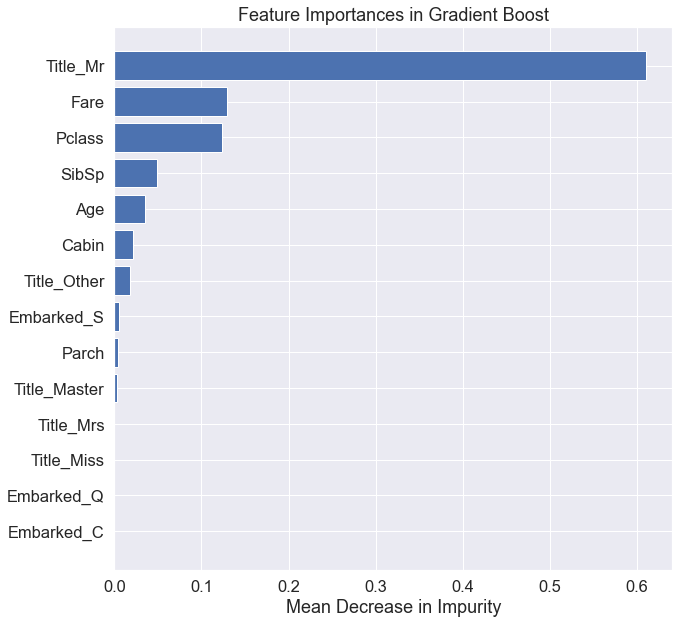

In [253]:
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.barh(importances['Feature'], importances['Importance'])#, yerr=std)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_title('Feature Importances in Gradient Boost')
plt.show()

We can see a comparison of values in part 5, but overall, it appears that gradient boosting performs worse than random forest models and is on par with our other models.

## Part 4: Neural Networks

Carry on the classification by using feed forward neural networks, using functionality imported from [keras](https://keras.io/api/). You are responsible for choosing the number of layers, their corresponding size, the activation functions and the choice of gradient descent algorithm (and its parameters e.g. learning rate). Pick those parameters by hand. For some of them you can also perform cross-validation if you wish, but cross validation is not required. Your goal is to tune those parameters so that your test accuracy is at least above 75%. 

Report your accuracy on the test set along with your choice of parameters. More specifically, report the number of layers, their size, the activation functions and your choice of optimization algorithm. 

It is a good exercise to experiment with different optimizers (gradient descent, stochastic gradient descent, AdaGrad etc), learning rates, batch sizes etc. to get a feeling of how they affect neural network training. Experiment with some of these options. What do you observe?

In [ ]:
!pip install tensorflow==2.7
!pip install keras==2.3.1

In [32]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

Using TensorFlow backend.


In [256]:
#non-imputed data (did not tune this to be higher than .75 accuracy, as I believe the imputed dataset matters more)
np.random.seed(0)
tf.random.set_seed(0)

# Define NN
model = Sequential()
model.add(Dense(20, input_dim=len(X_train.columns), activation='sigmoid')) # First layer defines input_dim
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid')) # For regression/classification, last layer of size 1
model.compile(loss='mse', optimizer='adam', metrics=['mse']) # No r2 metric available in keras

# Fit and predict with NN
model.fit(X_train, Y_train, epochs=50, batch_size=10, verbose=1)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

# Get metrics
print('AUC on training set: %.2f' % roc_auc_score(Y_train, yhat_train))
print('AUC on test set: %.2f' % roc_auc_score(Y_test, yhat_test))

Epoch 1/50
571/571 [==============================] - 0s 722us/step - loss: 0.2351 - mse: 0.2351
Epoch 2/50
571/571 [==============================] - 0s 109us/step - loss: 0.2295 - mse: 0.2295
Epoch 3/50
571/571 [==============================] - 0s 109us/step - loss: 0.2227 - mse: 0.2227
Epoch 4/50
571/571 [==============================] - 0s 107us/step - loss: 0.2177 - mse: 0.2177
Epoch 5/50
571/571 [==============================] - 0s 112us/step - loss: 0.2138 - mse: 0.2138
Epoch 6/50
571/571 [==============================] - 0s 107us/step - loss: 0.2116 - mse: 0.2116
Epoch 7/50
571/571 [==============================] - 0s 111us/step - loss: 0.2099 - mse: 0.2099
Epoch 8/50
571/571 [==============================] - 0s 112us/step - loss: 0.2079 - mse: 0.2079
Epoch 9/50
571/571 [==============================] - 0s 106us/step - loss: 0.2064 - mse: 0.2064
Epoch 10/50
571/571 [==============================] - 0s 110us/step - loss: 0.2055 - mse: 0.2055
Epoch 11/50
571/571 [========

In [257]:
pred_train = model.predict(X_train)
pred = model.predict(X_test)
pred_train[pred_train >= .5] = 1
pred_train[pred_train < .5] = 0
print(accuracy_score(Y_train,pred_train))

pred[pred >= .5] = 1
pred[pred < .5] = 0
print(accuracy_score(Y_test,pred))


0.7215411558669002
0.6993006993006993


In [258]:
#imputed data
np.random.seed(0)
tf.random.set_seed(0)

# Define NN
model = Sequential()
model.add(Dense(20, input_dim=len(X_train_new.columns), activation='sigmoid')) # First layer defines input_dim
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid')) # For regression/classification, last layer of size 1
model.compile(loss='mse', optimizer='adam', metrics=['mse']) # No r2 metric available in keras

# Fit and predict with NN
model.fit(X_train_new, Y_train_new, epochs=50, batch_size=10, verbose=1)
yhat_train = model.predict(X_train_new)
yhat_test = model.predict(X_test_new)

# Get metrics
print('AUC on training set: %.2f' % roc_auc_score(Y_train_new, yhat_train))
print('AUC on test set: %.2f' % roc_auc_score(Y_test_new, yhat_test))

Epoch 1/50
712/712 [==============================] - 0s 600us/step - loss: 0.2294 - mse: 0.2294
Epoch 2/50
712/712 [==============================] - 0s 103us/step - loss: 0.2169 - mse: 0.2169
Epoch 3/50
712/712 [==============================] - 0s 103us/step - loss: 0.2030 - mse: 0.2030
Epoch 4/50
712/712 [==============================] - 0s 113us/step - loss: 0.1872 - mse: 0.1872
Epoch 5/50
712/712 [==============================] - 0s 112us/step - loss: 0.1722 - mse: 0.1722
Epoch 6/50
712/712 [==============================] - 0s 111us/step - loss: 0.1599 - mse: 0.1599
Epoch 7/50
712/712 [==============================] - 0s 112us/step - loss: 0.1506 - mse: 0.1506
Epoch 8/50
712/712 [==============================] - 0s 113us/step - loss: 0.1440 - mse: 0.1440
Epoch 9/50
712/712 [==============================] - 0s 114us/step - loss: 0.1395 - mse: 0.1395
Epoch 10/50
712/712 [==============================] - 0s 112us/step - loss: 0.1363 - mse: 0.1363
Epoch 11/50
712/712 [========

In [259]:
pred_train = model.predict(X_train_new)
pred = model.predict(X_test_new)
pred_train[pred_train >= .5] = 1
pred_train[pred_train < .5] = 0
print(accuracy_score(Y_train_new,pred_train))

pred[pred >= .5] = 1
pred[pred < .5] = 0
print(accuracy_score(Y_test_new,pred))

0.8525280898876404
0.8212290502793296


After messing around with parameters, I found that after a while, changes to optimizer, activation, and amount of layers and sizes all have minimal changes. Feature engineering is very important to get good results here.

## Part 5: Putting it all together!

Create a final table that summarizes the performance of your models as follows. What do you observe? Are there trends in which models and hyperparameters work best?

| Model | Cross-validated Performance   | Train Performance | Test Performance | Chosen Hyperparameters | 
|------|------|------| | |
|   Decision Tree        | 0.700484 | 0.85 | 0.65 | max_depth = 8, min_samples_leaf = 1 |
|   Decision Tree (with imputed missing values and new features) | 0.820167 | .85 | .80 | max_depth = 4, min_samples_leaf = 3 |
|   SVM  | 0.681326 | .68 | .65 | C = .4 |
|   SVM (with imputed missing values and new features)        | 0.832837 | .85 | .8 | C = .5 |
|   Random Forest        | 0.7390833103701663 | .82 | .76 | maximum depth: 9, number of estimators: 250, min samples split: 10, min samples leaf: 2 |
|   Random Forest (with imputed missing values and new features)        | 0.8259109550993394 | .88  | .82 | maximum depth: 9, number of estimators: 52, min samples split: 5, min samples leaf: 2 |
|   Gradient Boosting    | 0.7337742261412693 | .80 | .74 | max_depth = 3, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 52 |
|   Gradient Boosting (with imputed missing values and new features)        | 0.8315191055325083 | .85 | .79 | max_depth = 3, min_samples_leaf = 4, min_samples_split = 2, n_estimators = 20 |
|   Neural Network    | N/A | 0.7215411558669002 | 0.6993006993006993 | layers = 3, sizes= (20,10,1), activation = sigmoid, loss = mse, optimizer = adam, metrics = mse |
|   Neural Network (with imputed missing values and new features)        | N/A | 0.8525280898876404 | 0.8212290502793296 | layers = 3, sizes= (20,10,1), activation = sigmoid, loss = mse, optimizer = adam, metrics = mse |

It appears that decision trees an SVMs perform about the same on our test data. Random Forest performs slighly better and gradient boosting performs slightly worse. Our neural network with imputed data and feature engineering performs as well as the random forest model with imputed values and new features. Overall, it appears that random forest perfoms the best for this set of data overall. We can see that our models using imputed data and new features perform better in every case.

## Part 6: (Extra credit) Flex your ML chops

Add additional rows to the table from Part 5 based on other models you've learned in class.
 - Which models perform the best, using the default parameters (i.e., no hyperparameter tuning)?
 - How do models perform in terms of performance metrics beyond accuracy? (e.g. AUC score, precision, recall) 
 - For which models does careful hyperparameter tuning make the biggest different? Why do you think that is the case?
 - Which tuned model has the largest gap between cross-validated performance and test performance? Why might that be?

In [ ]:
# Your code here

*Your observations here*